## Table of Contents

- [Section 0: Models Introduction](#cell-aXiSvPd-RrjN)
- [Section 1: Zero shot inference](#cell-Bs8GNXS5ukzf)
- [Section 2: Few shot inference](#cell-9-vNLs8Vkfci)
- [Section 3: Related-example selection](#cell-S2k-8YErxHjm)
- [Section 4: More Error analysis](#cell-p1JrEjDluWpH)
  - [4.1: **Full Explainations on Error analysis**](#cell-a8XYa9r-TeLc)
- [Section 5: Cut tokenization overhead](#cell-cELyQNNDz4Lm)
- [Section 6: Ensemble Model](#cell-0rEcrKWh1kOi)
- [Section 7: Test on A1 dataset](#cell-0YMVGK3Y2XOW)
- [Section 8: Some more analyze with demonstration dataset as test](#cell-E1Bq2SdLlSCp)






In this experiment, we plot the misclassified instances in two bar plots (false negatives and false positives only) instead of using a confusion matrix, for two reasons:

  1- The number of sexist and non-sexist instances is equal and we only got two categories, so subtracting half the total data from the false positives or false negatives gives the number of correctly labeled instances.

  2- Bar plots better visualize the imbalance between false negatives and false positives.

In [ ]:
!git clone https://github.com/nlp-unibo/nlp-course-material.git

Cloning into 'nlp-course-material'...
remote: Enumerating objects: 365, done.
remote: Counting objects: 100% (365/365), done.
remote: Compressing objects: 100% (267/267), done.
remote: Total 365 (delta 162), reused 279 (delta 85), pack-reused 0 (from 0)
Receiving objects: 100% (365/365), 7.26 MiB | 19.46 MiB/s, done.
Resolving deltas: 100% (162/162), done.


### Load datasets

In [ ]:
import pandas as pd

# Load CSV file into a DataFrame
a2_test = pd.read_csv('/kaggle/working/nlp-course-material/2024-2025/Assignment 2/data/a2_test.csv')

# Display the first few rows of the DataFrame

# Load CSV file into a DataFrame
demos = pd.read_csv('/kaggle/working/nlp-course-material/2024-2025/Assignment 2/data/demonstrations.csv')



Preprocess the labels to (1, 0) for demonstration dataset

In [ ]:
import pandas as pd
import copy

# Sample DataFrame
dfdem = demos.copy()

# Define the mapping
label_mapping = {'not sexist': 0, 'sexist': 1}

# Apply the mapping to the 'label' column
dfdem['label_sexist'] = dfdem['label_sexist'].map(label_mapping)

# Display the DataFrame
dfdem.head()


,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,0
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,1
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,0
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,1
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,1


In [ ]:
a2_test.head()

Preprocess the labels to (1, 0) for a2-test dataset

In [ ]:
import pandas as pd
import copy

# Sample DataFrame
dfa2 = a2_test.copy()

# Define the mapping
label_mapping = {'not sexist': 0, 'sexist': 1}

# Apply the mapping to the 'label' column
dfa2['label_sexist'] = dfa2['label_sexist'].map(label_mapping)

# Display the DataFrame
dfa2.head()


,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,0
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,1
2,sexism2022_english-3018,Old man mogs everyone in this sub,0
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",0
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,1


## **Models Introduction**

| Model                         | Architecture & Family                                                                                                              | Parameter Count    | Embedding Dimension & Style                                                                                                      | Similarity to Common Embeddings                                                                                  | Notable “Folds” or Versions                                                                                                                   |
|-------------------------------|------------------------------------------------------------------------------------------------------------------------------------|-------------------|---------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------|
| Llama/Llama-3.1-8B-Instruct    | - Likely based on Meta’s LLaMA series with transformer blocks, multi-head attention, and RoPE embeddings.                          | ~8B (estimated)    | - Typically 4,096 token embedding dimension (similar to LLaMA 2 7B–13B range).                                                  | - Transformer-based embeddings, learned end-to-end.                                                               | - Officially, LLaMA 2 offers 7B, 13B, 70B. “3.1” could be a community or future version.                                                       |
| (unofficial or hypothetical)   | - The “3.1” might refer to an internal or third-party iteration beyond Llama 2.                                                    |                   | - Uses a subword tokenizer.                                                                                                     | - Conceptually similar to BERT-style in being a large Transformer, but obviously different from Word2Vec/TF-IDF.  | - Usually tested on the same benchmarks used for LLaMA 2.                                                                                      |
| Phi-3.5-mini-instruct          | - Likely a GPT-style architecture, with modifications for instruction tuning.                                                      | ~3.5B (approx.)    | - Embedding dimension not publicly stated; can be 2,048–3,200 (typical range for 3–4B param GPT-like).                          | - A Transformer with learned embeddings at the subword level.                                                    | - “mini-instruct” suggests a smaller variant of a larger family.                                                                               |
|                               |                                                                                                                                    |                   | - Subword (BPE) tokenizer.                                                                                                      | - Similar to GPT/BERT in concept (i.e., multi-layer attention), not like Word2Vec or TF-IDF.                       | - Usually has multiple “checkpoint” versions or RLHF-tuned variants.                                                                           |
| Mistral v0.3                   | - Mistral is a new open-source LLM project focusing on 7B–13B param ranges.                                                        | ~7B (main model)   | - Embedding dimension: ~4,096 (similar to LLaMA 2 7B).                                                                          | - Transformer-based embeddings, learned for auto-regressive tasks.                                               | - Mistral’s official releases so far mention “v0.1” or “v0.3”.                                                                                |
|                               | - Uses GPT-like, decoder-only architecture with FlashAttention, multi-query attention, etc.                                        |                   | - SentencePiece or BPE subword tokenizer.                                                                                       | - Behaviorally similar to LLaMA or GPT (so also more “BERT-like” than Word2Vec/TF-IDF).                         | - Typically tested on standard LLM benchmarks.                                                                                                |

(This table is GPT generated)


# LOAD phi-3.5 model

In [ ]:
from transformers import BitsAndBytesConfig
import torch
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

model_card = "microsoft/Phi-3.5-mini-instruct"

tokenizer_phi = AutoTokenizer.from_pretrained(model_card)
tokenizer_phi.pad_token = tokenizer_phi.eos_token

terminators = [
    tokenizer_phi.eos_token_id,
    tokenizer_phi.convert_tokens_to_ids("<|eot_id|>")
]

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_card,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='auto'
)

model-00001-of-00002.safetensors:   7%|6         | 325M/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

# LOAD Llama-3.1 model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
import torch
from huggingface_hub import login

login(token="token")



# Model configuration
model_card = "meta-llama/Llama-3.1-8B-Instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load tokenizer and model
tokenizer_llama = AutoTokenizer.from_pretrained(model_card, use_fast=False)
tokenizer_llama.pad_token = tokenizer_llama.eos_token

model_llama = AutoModelForCausalLM.from_pretrained(
    model_card,
    quantization_config=bnb_config,
    device_map="auto",
)



tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

# LOAD Mistral-v0.3 model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
import torch
from huggingface_hub import login

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

login(token="token")


# Model configuration
model_card = "mistralai/Mistral-7B-Instruct-v0.3"

# Quantization configuration for loading in 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load tokenizer
tokenizer_mistral = AutoTokenizer.from_pretrained(model_card, use_fast=False)
tokenizer_mistral.pad_token = tokenizer_mistral.eos_token  # Ensure pad_token is set

# Load model
model_mistral = AutoModelForCausalLM.from_pretrained(
    model_card,
    quantization_config=bnb_config,
    device_map="auto",  # Automatically map the model to available GPUs
)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Defining functions for tasks 2,3,4 (zero shot task)

In [ ]:
def prepare_prompts(texts, prompt_template, tokenizer, phi= True):
    if phi:
        prompt_template = tokenizer.apply_chat_template(prompt_template, tokenize=False, add_generation_prompt=True)
    return [tokenizer(prompt_template.format(text=example_text), return_tensors='pt').to('cuda') for example_text in texts]

def generate_responses(model, prompt_examples, tokenizer):
    generation_config = model.generation_config
    generation_config.max_new_tokens = 100
    generation_config.eos_token_id = tokenizer.eos_token_id
    generation_config.pad_token_id = tokenizer.eos_token_id
    generation_config.temperature = None
    generation_config.num_return_sequences = 1
    outs = []
    for inp in prompt_examples:
        generated = model.generate(input_ids=inp['input_ids'],
                                   attention_mask=inp['attention_mask'],
                                   generation_config=generation_config,
                                   do_sample=False)
        outs.append(tokenizer.batch_decode(generated, skip_special_tokens=True)[0])
    return outs

def process_response(response):
    response = response.strip().upper()
    if "YES" in response:
        return 1
    elif "NO" in response or "NOT" in response:
        return 0
    else:
        return -1  # Invalid response

def compute_metrics(predictions, labels):
    accuracy = sum([p == l for p, l in zip(predictions, labels)]) / len(labels)
    fail_ratio = sum([r not in [0, 1] for r in predictions]) / len(predictions)
    return {"accuracy": accuracy, "fail_ratio": fail_ratio}, predictions, labels

def split_string(input_string, key= "SENTIMENT"):
    parts = input_string.split(key, 1)
    before_sentiment = parts[0].strip()

    after_sentiment = key + parts[1].strip() if len(parts) > 1 else ''

    return before_sentiment, after_sentiment

def evaluator(texts, labels, prompt, tokenizer, model, phi=True, key="SENTIMENT"):

    a = prepare_prompts(texts, prompt, tokenizer, phi)

    b = generate_responses(model, a, tokenizer)
    preds = []
    for i in b:
        answer = split_string(i,key)
        tmp = process_response(answer[1])
        preds.append(tmp)

    a,b,c = compute_metrics(preds,labels)
    print(a)
    return b, c

import matplotlib.pyplot as plt

def analyze_wrong_predictions(predictions, labels):
    if len(predictions) != len(labels):
        raise ValueError("Predictions and labels must have the same length.")

    wrong_indices = [i for i, (pred, label) in enumerate(zip(predictions, labels)) if pred != label]

    print(f"Indices of wrong predictions: {wrong_indices}")

    wrong_labels = [labels[i] for i in wrong_indices]

    category_0 = wrong_labels.count(0)
    category_1 = wrong_labels.count(1)

    # Plot the results
    categories = ['Label 0', 'Label 1']
    counts = [category_0, category_1]

    plt.bar(categories, counts)
    plt.title("Wrong Predictions by Category")
    plt.ylabel("Number of Wrong Predictions")
    plt.xlabel("True Label")
    plt.show()

def wrong_counter(predictions, labels):
    if len(predictions) != len(labels):
        raise ValueError("Predictions and labels must have the same length.")

    wrong_indices = [i for i, (pred, label) in enumerate(zip(predictions, labels)) if pred != label]

    return wrong_indices


prompt_phi = [
    {
        'role': 'system',
        'content': 'You are an annotator for sentiment analysis.'
    },
    {
        'role': 'user',
        'content': """Classify the text into sexism or not.
        Respond only Yes or No.

        TEXT:
        {text}

        SENTIMENT:
        """
    }
]

prompt_llama = """Classify the following text into "Yes" (sexist) or "No" (not sexist).

TEXT:
{text}

Answer:"""


## ZERO SHOT: <a id="zero-shot"></a>


| Model         | Prompt-version (As Reported/Ours) | Accuracy (%) (full dataset) |
|---------------|-------------------------------------|-----------------------------|
| **LLaMA**     | A.R.                                 | 0                         |
| **LLaMA**     | ours                                 | 67                           |
| **Phi-3**     | A.R.*                                 | 61                           |
| **Phi-3**     | ours                                 | 0                           |
| **mistral**     | A.R.*                                 | 65                         |
| **mistral**     | ours                                 | 71                           |


#### * first of all, we had a problem to get any result from llama model by injecting the given prompt, hence, we tried to change our prompt for llama and surprisingly llama could generate response for changed prompt
#### * secondly, we tried to inject phi-3 with our crafted prompt for sake of comparison but surprisingly phi-3 could not generate any response for our prompt
##### * these points seams odd to us
#### * however by injecting both prompts to mistral it could generate responses and as it presented our prompt seams more suitable for this tasks
### * These results shows that prompting currectly can change result in great deal (6% is not negligible)

### Mode: zero inference
### dataset: whole a2-test
### model: Llama 3.1
### only one instance failed to be labeled in valid way (it labeled neither "yes", nor "no")
### prompt: our own prompt text
### 67% accuracy

In [ ]:
import time
start_time = time.time()
preds_phi_one, labels_phi_one = evaluator(dfa2["text"], dfa2["label_sexist"], prompt_llama, tokenizer_llama, model_llama, phi= False, key="Answer")
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))

{'accuracy': 0.6766666666666666, 'fail_ratio': 0.0033333333333333335}
time spent: 32.72105479637782


Indices of wrong predictions: [3, 6, 7, 8, 10, 13, 18, 19, 22, 26, 34, 44, 46, 47, 53, 54, 58, 59, 61, 65, 67, 68, 72, 75, 80, 84, 85, 89, 90, 91, 93, 94, 98, 102, 107, 114, 117, 120, 122, 123, 124, 125, 126, 129, 130, 134, 137, 138, 140, 141, 143, 147, 149, 156, 159, 161, 162, 168, 170, 171, 177, 179, 187, 190, 191, 192, 193, 198, 206, 210, 211, 215, 219, 220, 224, 225, 226, 229, 231, 239, 245, 246, 247, 249, 252, 253, 257, 259, 262, 263, 270, 278, 280, 283, 289, 294, 295]


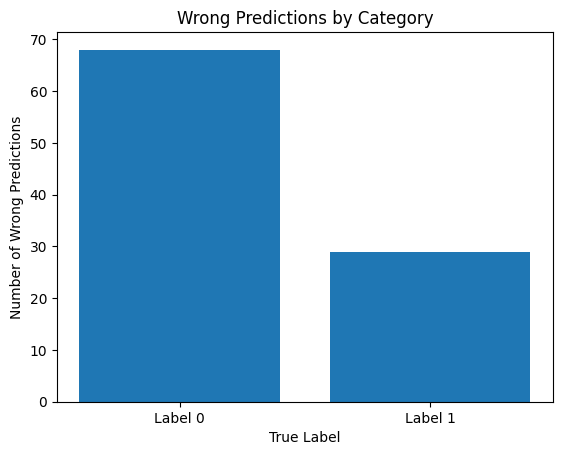

In [ ]:
analyze_wrong_predictions(preds_phi_one, labels_phi_one)

### zero inference
### dataset: whole a2-test
### model: phi-3
### prompt: As reported in the doc
### 61% accuracy

In [ ]:
import time
start_time = time.time()
preds_la_one, labels_la_one = evaluator(dfa2["text"], dfa2["label_sexist"], prompt_phi, tokenizer_phi, model, phi= True)
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))

{'accuracy': 0.6166666666666667, 'fail_ratio': 0.0}
time spent: 11.972946095466614


Indices of wrong predictions: [2, 3, 5, 6, 10, 14, 17, 24, 27, 34, 38, 39, 44, 46, 47, 48, 52, 53, 57, 58, 59, 60, 61, 62, 64, 67, 71, 74, 80, 84, 85, 90, 91, 93, 94, 97, 98, 102, 107, 111, 114, 117, 120, 121, 122, 123, 126, 130, 133, 134, 135, 137, 138, 141, 143, 144, 146, 149, 152, 158, 159, 162, 164, 168, 171, 173, 177, 178, 179, 186, 187, 190, 191, 192, 193, 197, 200, 205, 206, 207, 209, 211, 212, 215, 219, 220, 224, 226, 229, 231, 232, 233, 235, 236, 248, 253, 254, 255, 257, 259, 262, 265, 270, 271, 274, 276, 278, 281, 282, 284, 292, 294, 295, 297, 298]


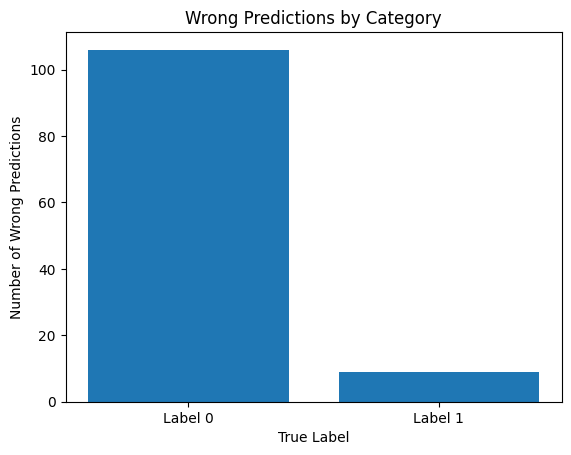

In [ ]:
analyze_wrong_predictions(preds_la_one, labels_la_one)

### Mode: zero inference
### dataset: whole a2-test
### model: mistral
### only one prompt failed to labeled valid (it labeled neither "yes", nor "no")
### prompt: As reported in doc
### 65% accuracy

In [ ]:
import time
start_time = time.time()
preds_phi_one, labels_phi_one = evaluator(dfa2["text"], dfa2["label_sexist"], prompt_phi, tokenizer_mistral, model_mistral, phi= True)
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))

{'accuracy': 0.65, 'fail_ratio': 0.0}
time spent: 4.136727956930796


### Mode: zero inference
### dataset: whole a2-test
### model: mistral
### only one prompt failed to labeled valid (it labeled neither "yes", nor "no")
### prompt: Our own prompt text
### 65% accuracy

In [ ]:
import time
start_time = time.time()
preds_phi_one, labels_phi_one = evaluator(dfa2["text"], dfa2["label_sexist"], prompt_llama, tokenizer_mistral, model_mistral, phi= False, key= "Answer")
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))

{'accuracy': 0.7166666666666667, 'fail_ratio': 0.0}
time spent: 28.059589250882468


## Table of Contents

- [Section 1: Zero shot inference](#cell-Bs8GNXS5ukzf)
- [Section 2: Few shot inference](#cell-9-vNLs8Vkfci)
- [Section 3: Related-example selection](#cell-S2k-8YErxHjm)
- [Section 4: More Error analysis](#cell-p1JrEjDluWpH)
  - [4.1: **Full Explainations on Error analysis**](#cell-a8XYa9r-TeLc)
- [Section 5: Cut tokenization overhead](#cell-cELyQNNDz4Lm)
- [Section 6: Ensemble Model](#cell-0rEcrKWh1kOi)
- [Section 7: Test on A1 dataset](#cell-0YMVGK3Y2XOW)
- [Section 8: Some more analyze with demonstration dataset as test](#cell-E1Bq2SdLlSCp)






## Defining functions for task 5 and 6 (few shot task)

In [ ]:
prompt_few = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

def prepare_prompts_few(exmps, texts, prompt_template, tokenizer, phi=True):
    if phi:
        prompt_template = tokenizer.apply_chat_template(prompt_template, tokenize=False, add_generation_prompt=True)

    # Validate examples and texts
    if not exmps or not texts:
        raise ValueError("Examples and texts must be non-empty lists.")

    # Format examples into a single string
    examples_str = "\n\n".join(exmps)

    # Combine examples and texts into prompts
    prompts = [
        prompt_template.format(examples=examples_str, text=text)
        for text in texts
    ]
    #print(prompts)

    # Tokenize all prompts
    return [
        tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to('cuda')
        for prompt in prompts
    ]

def build_few_shot_demonstrations(demonstrations, num_per_class=2, exm_mode=True):
    demonstrations = demonstrations.dropna(subset=['label_sexist'])

    examples = []
    labels = []

    if exm_mode:
        share = int(num_per_class / 2)
        for label, label_str in [(1, "YES"), (0, "NO")]:
            sampled_examples = demonstrations[demonstrations["label_sexist"] == label].sample(
                n=min(share, len(demonstrations[demonstrations["label_sexist"] == label])),
                random_state=42,
                replace=True
            )
            for _, row in sampled_examples.iterrows():
                examples.append(f"Text: {row['text']}\nANSWER: {label_str}")
    else:
        sampled = demonstrations.sample(n=min(num_per_class, len(demonstrations)), random_state=42, replace=True)
        for _, row in sampled.iterrows():
            examples.append(row["text"])
            labels.append(row["label_sexist"])

    return examples, labels

def split_string(input_string, key="ANSWER"):
    """
    Splits the input string by all occurrences of the key and returns the last segment
    after the final occurrence of the key.
    """
    # Split the string by the key into all parts
    parts = input_string.split(key)

    # Filter out empty or whitespace-only parts
    parts = [part.strip() for part in parts if part.strip()]

    # Return the last part if it exists, otherwise return an empty string
    if parts:
        return parts[-1]
    else:
        return ""

def few_evaluator(data, num_exmp, tokenizer, model, prompt_template, text, labels, phi=True, key="ANSWER"):
    examples, _ = build_few_shot_demonstrations(data, num_exmp)
    tokenized_prompts = prepare_prompts_few(examples, text, prompt_template, tokenizer, phi=phi)    # Generate responses
    # Generate responses
    responses = generate_responses(model, tokenized_prompts, tokenizer)
    #print(responses)
    #print(responses)

    # Process responses into binary predictions
    predictions = []
    for response in responses:
        # Extract the last segment after the final "ANSWER"
        answer = split_string(response, key="ANSWER")
        #print(f"DEBUG: Extracted Answer: {answer}")  # Debugging extracted answer
        # Process the response to determine "YES" or "NO"
        predictions.append(process_response(answer))

    return predictions


# FEW SHOT:

| Model         | Example Ratio (Sexist : Not-Sexist) | Accuracy (%) (full dataset) | Time (minute) |
|---------------|-------------------------------------|-----------------------------|---------------|
| **LLaMA**     | 1:1                                 | 56                          | 4             |
| **LLaMA**     | 2:2                                 | 55                           | 5             |
| **LLaMA**     | 3:3                                 | 55                          | 5.8           |
| **Phi-3**     | 1:1                                 | 64                          | 7             |
| **Phi-3**     | 2:2                                 | 63                          | 8             |
| **Phi-3**     | 3:3                                 | 60                          | 10            |
| **mistral**   | 1:1                                 | 59                          | 6.5           |
| **mistral**   | 2:2                                 | 65                          | 7             |
| **mistral**   | 3:3                                 | 66                          | 9             |
| **mistral**   | 5:5                                 | 70                          | 9.5           |
| **mistral**   | 7:7                                 | 71                          | 11            |
| **mistral**   | 10:10                                 | 70                          | 15            |


### As the results presented, increasing the number of example doesn't improve the accuracy in LLama and phi-3 model which shows that they are sensetive to the input and length of prompt they injected with
### On the other hand, mistral shows improvment in accuracy by increasing the number of examples which is promising

| Model         | best zero shot | best few shot |
|---------------|-------------------------------------|-----------------------------|
| **LLaMA**     | 67                                 | 56                         |
| **Phi-3**     | 61                                 | 61                           |
| **mistral**     | 71                                 | 71                         |


## As we observed, we found out, prompting LLM models such as: Llama 3.1, phi-3, mistral,,, will have same pattern, which is at best their few-shot inference performance will be equal to their zero shot
## and also this can shows that learning in these LLMs by injecting the informations, at least in the way we applied, models lose their generality
## however, mistral shows more promising results which demonstrate that giving it more information will lead to better result, however it still can be less than prompting with shorter texts and informations

Here we put best reseults for the normal configurations as required in the doc, in continue we will present cells regard all the runs with different configurations as proof

#### Model: llama
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 2
#### accuracy: 56%
#### time: 4 mins

Evaluation Metrics: {'accuracy': 0.5633333333333334, 'fail_ratio': 0.0}
time spent: 4.1703231493632
Indices of wrong predictions: [0, 2, 3, 6, 7, 10, 14, 15, 17, 23, 24, 26, 27, 32, 34, 38, 44, 46, 47, 48, 51, 52, 53, 54, 57, 58, 60, 61, 62, 64, 65, 67, 71, 72, 74, 84, 85, 89, 90, 91, 93, 94, 97, 100, 101, 102, 107, 108, 111, 114, 117, 119, 120, 121, 122, 123, 125, 126, 130, 133, 136, 137, 138, 141, 143, 146, 147, 149, 152, 158, 159, 161, 162, 164, 168, 171, 172, 173, 177, 178, 179, 181, 186, 187, 190, 191, 192, 193, 195, 196, 199, 200, 205, 206, 207, 209, 211, 212, 215, 219, 224, 226, 229, 231, 232, 233, 235, 236, 242, 248, 253, 254, 255, 257, 262, 265, 270, 274, 276, 277, 278, 281, 282, 283, 285, 286, 294, 295, 296, 297, 298]


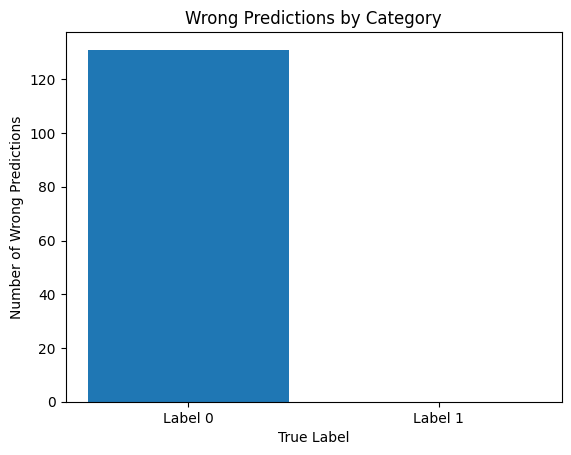

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 2, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

#### Model: phi-3
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 2
#### accuracy: 64%
#### time: 7 mins

Evaluation Metrics: {'accuracy': 0.64, 'fail_ratio': 0.0}
time spent: 7.142983945210775
Indices of wrong predictions: [3, 6, 8, 14, 17, 27, 34, 38, 44, 45, 46, 47, 48, 52, 53, 58, 61, 62, 64, 67, 71, 74, 75, 80, 85, 90, 91, 93, 94, 96, 97, 98, 102, 107, 108, 111, 114, 117, 119, 120, 121, 122, 123, 126, 130, 136, 137, 138, 141, 143, 146, 147, 149, 152, 158, 159, 168, 171, 172, 177, 179, 181, 186, 187, 190, 192, 193, 195, 196, 197, 200, 206, 209, 210, 211, 212, 215, 216, 219, 220, 224, 226, 229, 231, 232, 233, 236, 242, 246, 248, 253, 254, 255, 257, 262, 265, 270, 274, 278, 282, 283, 284, 289, 292, 294, 295, 297, 298]


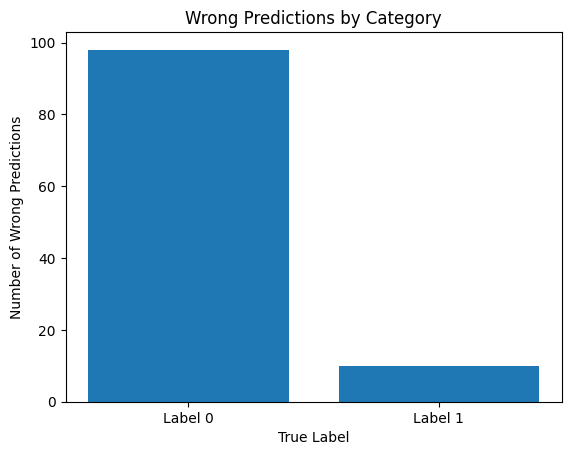

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 2, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

#### Model: mistral
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 14
#### accuracy: 71%
#### time: 11 mins

Evaluation Metrics: {'accuracy': 0.71, 'fail_ratio': 0.0}
Time spent: 11.721255719661713
Indices of wrong predictions: [3, 6, 8, 10, 12, 18, 30, 37, 38, 43, 44, 48, 52, 54, 57, 58, 59, 60, 61, 62, 67, 71, 74, 80, 85, 89, 91, 94, 97, 102, 107, 114, 117, 120, 121, 122, 123, 137, 138, 140, 141, 143, 146, 149, 152, 154, 159, 167, 168, 170, 171, 175, 177, 178, 187, 192, 203, 206, 209, 211, 215, 219, 220, 223, 224, 226, 229, 231, 232, 236, 245, 246, 247, 249, 253, 257, 262, 265, 269, 274, 277, 278, 284, 291, 295, 297, 298]


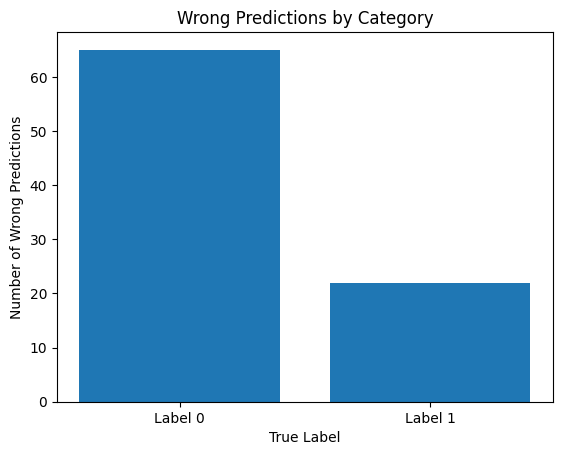

In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 14, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

### In below there are runs for few inference shot for different number of examples for our 3 models
### these are the runs that they mentioned in the table before

#### Model: llama
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 4
#### accuracy: 55%
#### time: 5 mins

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 4, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))


Evaluation Metrics: {'accuracy': 0.55, 'fail_ratio': 0.0}
time spent: 5.3322049101193745


Indices of wrong predictions: [2, 3, 6, 7, 10, 14, 17, 23, 24, 26, 27, 32, 34, 38, 39, 44, 46, 47, 48, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 67, 71, 72, 74, 80, 81, 85, 89, 90, 91, 93, 94, 96, 97, 100, 101, 102, 107, 108, 111, 114, 117, 120, 121, 122, 123, 125, 126, 130, 133, 135, 136, 137, 138, 141, 143, 146, 147, 149, 152, 158, 159, 161, 162, 164, 168, 171, 172, 173, 177, 178, 179, 185, 186, 187, 190, 191, 192, 193, 195, 196, 199, 200, 205, 206, 207, 209, 211, 212, 215, 216, 219, 224, 226, 229, 231, 232, 233, 235, 236, 242, 248, 253, 254, 255, 257, 262, 265, 270, 274, 276, 277, 278, 281, 282, 283, 285, 286, 294, 295, 296, 297, 298]


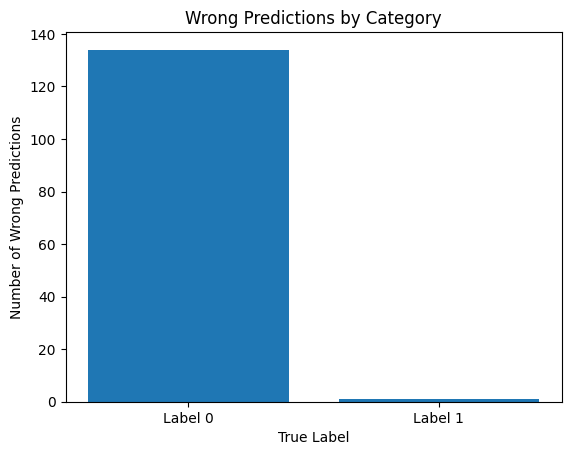

In [ ]:
analyze_wrong_predictions(preds_la_few, labels_la_few)

#### Model: llama
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 6
#### accuracy: 55%
#### time: 5.8 mins

Evaluation Metrics: {'accuracy': 0.5533333333333333, 'fail_ratio': 0.0}
time spent: 5.873621233304342
Indices of wrong predictions: [2, 3, 6, 7, 10, 14, 17, 23, 24, 26, 27, 32, 34, 38, 39, 44, 46, 47, 48, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 67, 71, 72, 74, 80, 81, 85, 89, 90, 91, 93, 94, 96, 97, 100, 101, 102, 104, 107, 108, 111, 114, 117, 120, 121, 122, 123, 125, 126, 130, 133, 136, 137, 138, 141, 143, 146, 147, 149, 152, 158, 159, 161, 162, 164, 168, 171, 172, 173, 177, 178, 179, 181, 186, 187, 188, 190, 191, 192, 193, 195, 196, 199, 200, 205, 206, 207, 209, 211, 212, 215, 216, 219, 224, 226, 229, 231, 232, 233, 235, 236, 242, 248, 253, 254, 255, 257, 262, 265, 270, 274, 276, 277, 278, 281, 282, 283, 285, 294, 295, 296, 297, 298]


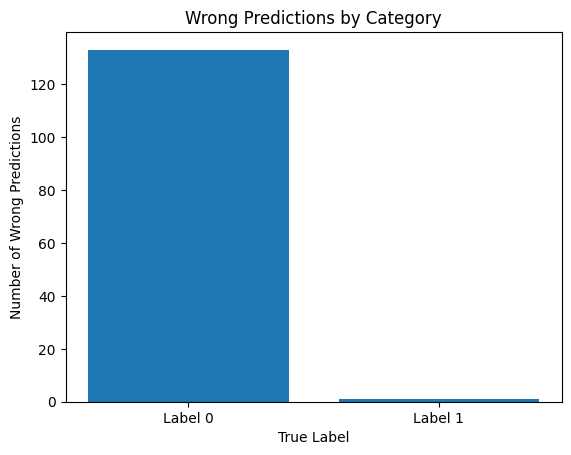

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 6, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

#### Model: phi-3
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 4
#### accuracy: 63%
#### time: 8 mins

Evaluation Metrics: {'accuracy': 0.63, 'fail_ratio': 0.0}
time spent: 8.719098309675852
Indices of wrong predictions: [3, 5, 6, 7, 8, 14, 17, 27, 34, 38, 44, 46, 47, 48, 52, 53, 57, 58, 59, 61, 62, 64, 65, 67, 71, 72, 74, 78, 80, 85, 89, 90, 91, 93, 94, 96, 97, 102, 104, 107, 111, 114, 117, 120, 121, 122, 123, 126, 130, 133, 134, 136, 137, 141, 142, 143, 146, 149, 152, 159, 161, 164, 168, 171, 172, 173, 177, 179, 186, 187, 190, 192, 193, 195, 197, 200, 201, 206, 209, 211, 212, 215, 216, 219, 220, 224, 226, 229, 231, 232, 236, 245, 248, 249, 252, 253, 255, 257, 259, 262, 265, 270, 282, 283, 284, 289, 292, 294, 295, 297, 298]


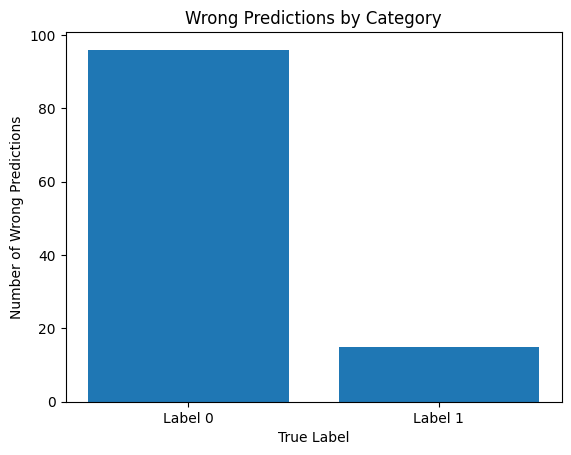

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 4, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

#### Model: phi-3
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 6
#### accuracy: 60%
#### time: 10 mins

Evaluation Metrics: {'accuracy': 0.6033333333333334, 'fail_ratio': 0.0}
time spent: 10.065662542978922
Indices of wrong predictions: [2, 3, 5, 6, 8, 10, 12, 14, 27, 29, 34, 38, 39, 44, 46, 48, 53, 54, 57, 58, 59, 61, 62, 64, 65, 68, 71, 72, 74, 80, 81, 85, 89, 90, 91, 93, 94, 96, 97, 98, 102, 104, 107, 108, 111, 114, 115, 117, 119, 120, 121, 122, 123, 124, 133, 135, 136, 137, 141, 144, 146, 149, 152, 158, 159, 161, 162, 167, 168, 171, 172, 173, 177, 178, 179, 186, 190, 192, 193, 195, 197, 199, 200, 201, 202, 205, 206, 211, 212, 215, 216, 219, 222, 224, 226, 231, 232, 236, 242, 245, 246, 248, 249, 252, 253, 255, 257, 259, 262, 270, 282, 283, 284, 285, 292, 294, 295, 297, 298]


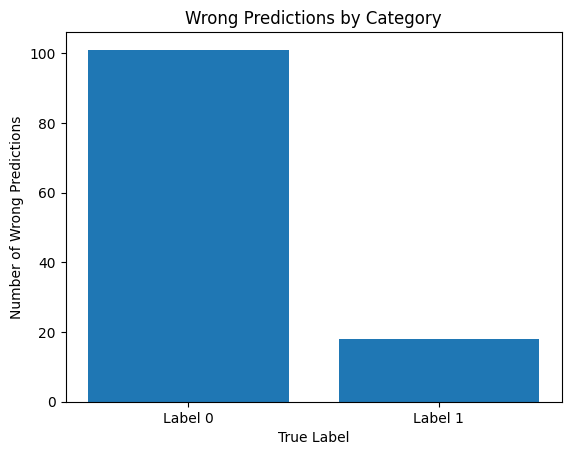

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 6, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

#### Model: mistral
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 4
#### accuracy: 65%
#### time: 9 mins

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluation Metrics: {'accuracy': 0.6566666666666666, 'fail_ratio': 0.0}
Time spent: 6.942345984776815
Indices of wrong predictions: [0, 3, 6, 8, 10, 26, 27, 32, 34, 38, 44, 46, 47, 48, 52, 53, 54, 57, 58, 60, 61, 62, 64, 67, 71, 72, 74, 85, 89, 90, 91, 94, 97, 101, 102, 107, 108, 114, 117, 120, 121, 122, 123, 125, 126, 130, 133, 136, 137, 138, 140, 141, 143, 146, 147, 149, 152, 158, 159, 165, 168, 170, 171, 177, 178, 179, 187, 190, 191, 192, 193, 196, 199, 200, 206, 209, 211, 215, 219, 220, 224, 226, 229, 231, 232, 236, 245, 253, 254, 255, 257, 262, 265, 270, 274, 277, 278, 282, 292, 294, 295, 297, 298]


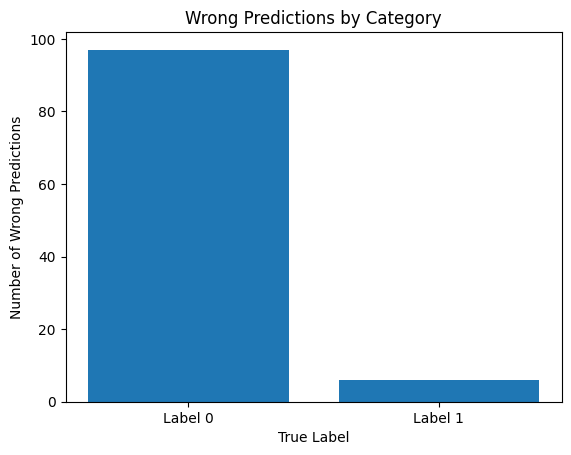

In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 4, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

#### Model: mistral
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 2
#### accuracy: 59%
#### time: 6.5 mins

Evaluation Metrics: {'accuracy': 0.5966666666666667, 'fail_ratio': 0.0}
Time spent: 6.563309482733408
Indices of wrong predictions: [0, 2, 3, 6, 7, 10, 15, 17, 23, 26, 27, 29, 32, 34, 38, 44, 46, 47, 48, 52, 53, 54, 57, 58, 60, 61, 62, 64, 65, 67, 71, 72, 74, 85, 89, 90, 91, 94, 97, 101, 102, 107, 108, 111, 114, 115, 117, 119, 120, 121, 122, 123, 125, 126, 130, 133, 135, 136, 137, 138, 140, 141, 143, 146, 147, 149, 152, 158, 159, 161, 162, 164, 168, 171, 172, 177, 178, 179, 181, 187, 190, 191, 192, 193, 195, 196, 199, 200, 205, 206, 209, 211, 215, 219, 224, 226, 229, 231, 232, 233, 236, 248, 253, 254, 255, 257, 262, 265, 270, 274, 277, 278, 282, 283, 288, 292, 294, 295, 296, 297, 298]


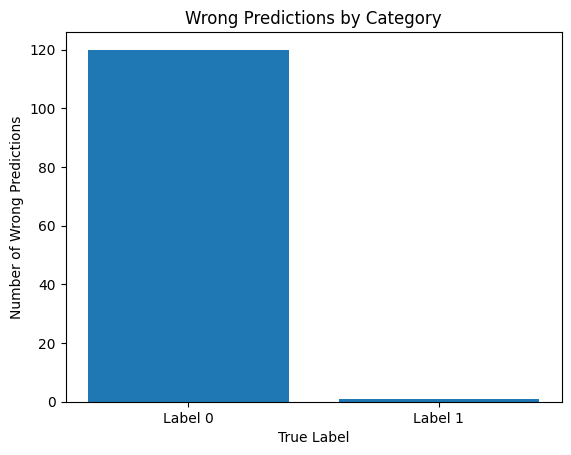

In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 2, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

#### Model: mistral
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 6
#### accuracy: 66%
#### time: 7 mins

Evaluation Metrics: {'accuracy': 0.6633333333333333, 'fail_ratio': 0.0}
Time spent: 7.3151167591412865
Indices of wrong predictions: [0, 3, 6, 8, 10, 17, 23, 26, 27, 32, 34, 38, 44, 46, 47, 48, 52, 53, 54, 57, 58, 60, 61, 62, 64, 67, 71, 72, 74, 80, 85, 89, 91, 94, 97, 100, 102, 107, 108, 114, 117, 119, 120, 121, 122, 123, 126, 130, 133, 137, 138, 140, 141, 143, 146, 147, 149, 152, 158, 159, 168, 170, 171, 177, 178, 179, 187, 190, 191, 192, 193, 196, 199, 200, 205, 206, 209, 211, 215, 219, 224, 226, 229, 231, 232, 236, 245, 253, 255, 257, 262, 265, 270, 274, 277, 278, 282, 292, 295, 297, 298]


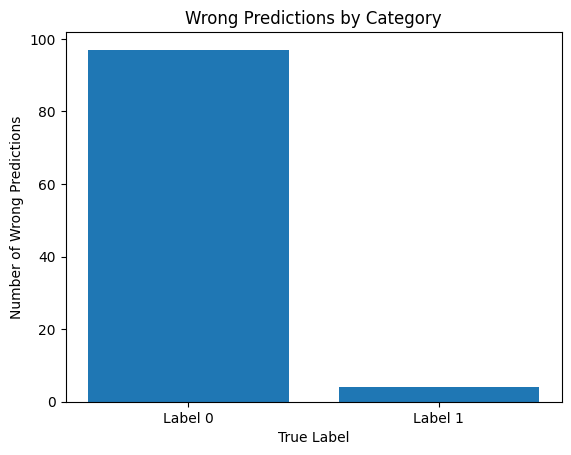

In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 6, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

#### Model: mistral
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 10
#### accuracy: 70%
#### time: 9.5 mins

Evaluation Metrics: {'accuracy': 0.7, 'fail_ratio': 0.0}
Time spent: 9.514805726210277
Indices of wrong predictions: [3, 6, 8, 10, 14, 18, 26, 32, 34, 38, 39, 44, 47, 48, 52, 54, 57, 58, 60, 61, 62, 64, 67, 74, 80, 85, 89, 91, 94, 97, 102, 107, 114, 117, 120, 121, 122, 123, 126, 133, 137, 138, 140, 141, 143, 146, 149, 152, 154, 158, 159, 167, 168, 170, 171, 177, 178, 187, 190, 192, 203, 205, 206, 209, 211, 215, 219, 220, 224, 226, 229, 231, 232, 236, 245, 246, 247, 253, 257, 262, 265, 269, 274, 277, 278, 284, 285, 295, 297, 298]


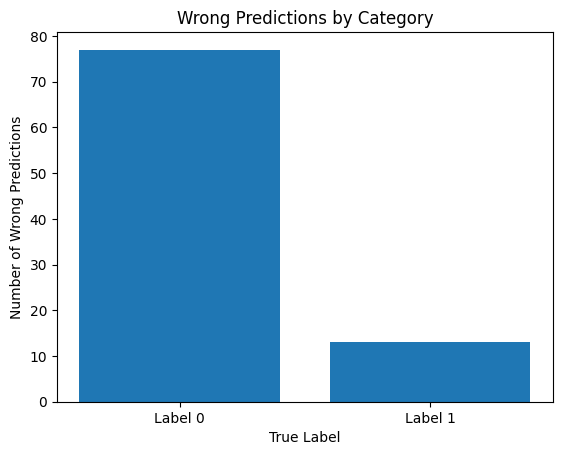

In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 10, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

#### Model: mistral
#### example sampling: demonstration dataset
#### text labeling: a2-test dataset
#### number of examples: 20
#### accuracy: 70%
#### time: 15 mins

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluation Metrics: {'accuracy': 0.7, 'fail_ratio': 0.0}
Time spent: 15.258608420689901
Indices of wrong predictions: [3, 5, 6, 8, 12, 14, 18, 30, 33, 35, 37, 43, 44, 48, 50, 52, 54, 58, 59, 61, 68, 71, 74, 75, 78, 80, 91, 92, 94, 97, 102, 110, 113, 114, 117, 122, 123, 134, 137, 140, 142, 143, 145, 146, 149, 150, 152, 154, 158, 165, 167, 168, 170, 175, 177, 178, 182, 187, 189, 192, 203, 206, 211, 215, 219, 220, 223, 224, 226, 229, 231, 234, 236, 240, 245, 246, 247, 249, 252, 253, 257, 262, 263, 265, 269, 273, 284, 291, 295, 298]


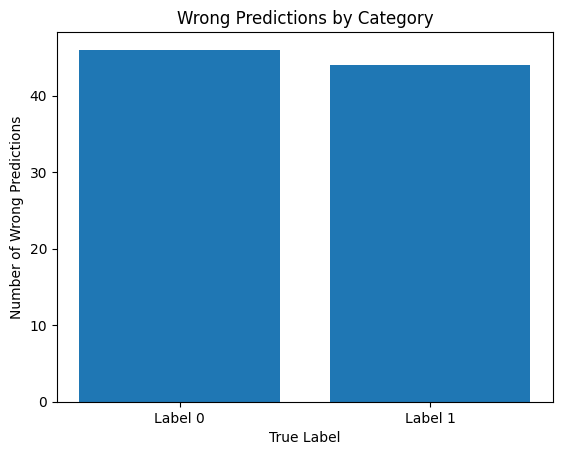

In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator(dfdem, 20, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

| Model         | best zero shot | best few shot |
|---------------|-------------------------------------|-----------------------------|
| **LLaMA**     | 67                                 | 56                         |
| **Phi-3**     | 61                                 | 61                           |
| **mistral**     | 71                                 | 71                         |


## Table of Contents

- [Section 1: Zero shot inference](#cell-Bs8GNXS5ukzf)
- [Section 2: Few shot inference](#cell-9-vNLs8Vkfci)
- [Section 3: Related-example selection](#cell-S2k-8YErxHjm)
- [Section 4: More Error analysis](#cell-p1JrEjDluWpH)
  - [4.1: **Full Explainations on Error analysis**](#cell-a8XYa9r-TeLc)
- [Section 5: Cut tokenization overhead](#cell-cELyQNNDz4Lm)
- [Section 6: Ensemble Model](#cell-0rEcrKWh1kOi)
- [Section 7: Test on A1 dataset](#cell-0YMVGK3Y2XOW)
- [Section 8: Some more analyze with demonstration dataset as test](#cell-E1Bq2SdLlSCp)






## define codes for text-aware example selection

In [ ]:
#####################TF-IDF###################
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def similarity_pre_phase(demonstration_dataset, column_name="text"):
    if isinstance(demonstration_dataset, pd.DataFrame):
        demonstration_dataset = demonstration_dataset[column_name].tolist()
    elif isinstance(demonstration_dataset, pd.Series):
        demonstration_dataset = demonstration_dataset.tolist()

    if not isinstance(demonstration_dataset, list):
        raise ValueError("demonstration_dataset must be a list of strings after conversion.")

    vectorizer = TfidfVectorizer()
    demo_tfidf_matrix = vectorizer.fit_transform(demonstration_dataset)

    return demonstration_dataset, demo_tfidf_matrix, vectorizer


def similar_example_retriever(demonstration_dataset, demo_tfidf_matrix, vec, text, k=3, column_name="text"):
    text_tfidf = vec.transform([text])
    similarities = cosine_similarity(text_tfidf, demo_tfidf_matrix)[0]
    top_k_indices = similarities.argsort()[::-1][:k]
    top_k_examples = [demonstration_dataset[i] for i in top_k_indices]

    return top_k_examples

########################################
###############WORD2VEC#################
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

nlp = spacy.load("en_core_web_md")

def sentence_to_vector_spacy(sentence, spacy_model):
    doc = spacy_model(sentence)
    if len(doc) == 0:
        return np.zeros(spacy_model.vocab.vectors_length)
    return doc.vector

def precompute_demo_vectors(demonstration_dataset, spacy_model):
    demo_texts = demonstration_dataset['text'].tolist()
    demo_vectors = np.array([sentence_to_vector_spacy(sent, spacy_model) for sent in demo_texts])
    return demo_texts, demo_vectors

def similar_example_retriever_word2vec(precomputed_texts, precomputed_vectors, text, k=3):
    text_vector = sentence_to_vector_spacy(text, nlp).reshape(1, -1)
    similarities = cosine_similarity(text_vector, precomputed_vectors)[0]
    top_k_indices = similarities.argsort()[::-1][:k]
    top_k_examples = [precomputed_texts[i] for i in top_k_indices]

    return top_k_examples

############################################
#################BERT-BASED#################
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

use_model_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
use_model = hub.load(use_model_url)

def use_pre_phase(demonstration_dataset, column_name="text"):
    demo_texts = demonstration_dataset[column_name].tolist()
    demo_embeddings = use_model(demo_texts)  # shape: [num_demo, 512] (approx)
    demo_embeddings = np.array(demo_embeddings)

    return demo_texts, demo_embeddings


def similar_example_retriever_use(demo_texts, demo_embeddings, text, k=3):
    text_embedding = use_model([text])
    text_embedding = np.array(text_embedding)
    similarities = cosine_similarity(text_embedding, demo_embeddings)[0]
    top_k_indices = similarities.argsort()[::-1][:k]
    top_k_examples = [demo_texts[i] for i in top_k_indices]

    return top_k_examples

#################FEW-SHOT-INJECTOR-WITH-CONTEXT-AWARE-METHODS##############################

def few_evaluator_retriever(data, num_exmp, tokenizer, model, prompt_template, text, labels, retriever_type=1, phi=True, key="ANSWER"):

    examples = []

    if retriever_type == 1:
        # TF-IDF Retriever
        for label, label_str in [(1, "YES"), (0, "NO")]:
            for text_input in text:
                d1, d2, vec = similarity_pre_phase(dfdem[dfdem["label_sexist"] == label])
                results = similar_example_retriever(d1, d2, vec, text_input, k=num_exmp // 2)
                for r in results:
                    examples.append(f"TEXT: {r}\nANSWER: {label_str}")

    elif retriever_type == 2:
        # Word2Vec Retriever
        for label, label_str in [(1, "YES"), (0, "NO")]:
            for text_input in text:
                d1, d2= use_pre_phase(data[data["label_sexist"] == label])
                results = similar_example_retriever_use(d1, d2, text_input, k=num_exmp // 2)
                for r in results:
                    examples.append(f"TEXT: {r}\nANSWER: {label_str}")

    elif retriever_type == 3:
        # BERT Retriever
        for label, label_str in [(1, "YES"), (0, "NO")]:
            for text_input in text:
                precomputed_texts, precomputed_vectors = precompute_demo_vectors(data[data["label_sexist"] == label], nlp)
                results = similar_example_retriever_word2vec(precomputed_texts, precomputed_vectors, text_input, k=num_exmp // 2)
                for r in results:
                    examples.append(f"TEXT: {r}\nANSWER: {label_str}")

    else:
        raise ValueError("Invalid retriever_type. Choose 1 (TF-IDF), 2 (Word2Vec), or 3 (BERT).")

    tokenized_prompts = prepare_prompts_few(examples, text, prompt_template, tokenizer, phi=phi)
    responses = generate_responses(model, tokenized_prompts, tokenizer)

    predictions = []
    for response in responses:
        answer = split_string(response, key="ANSWER")
        predictions.append(process_response(answer))

    return predictions


## related example selection

### in an experiment we used the more intelligent example injections
### instead of pick random examples, we inject the examples which are more similar to the text we want to evaluate
### our intuition was that it could increase the accuracy and time consumption

# extracting examples based on their relevance to the text to label

| Model       | TF-IDF | word2vec | Bert based | previous result with same number of examples |
|-------------|--------|------------|----------|---------------|
| **mistral** | 68% (9min) | 67% (11min) | 69% (41min)  | 70% (9min) |
| **LLaMA**   | 56% (4min) | 56% (6min)  | 58% (36min)  | 56%(4min)  |
| **Phi-3**   | 64% (3min) | 62% (5min)  | 66% (33min)  | 64% (7min) |
| **average** | 62% (5min) | 61% (7min)  | 64% (36min)  | 63% (6min) |

### * Bert-based method could increase the accuracy in llama and phi-3 models (but not in mistral); but the time-consumption increased in a GREAT deal (also this time consumption reported, belong to the whole process of tokenizing whole demonstration and texts and finding the best examples for each text to inject them + prompting time)
### * TF-IDF couldn't increase the accuracy but could optimize the time consumption
### * Word2vec couldn't optimize neither accuracy nor the time consumptions
# in total, by using better example injection in a way that the examples be more related to the text we want to examine, we can be optimistic that accuracy and time consumption optimized

### experiments on mistral:
#### 10 example injection since it was good based on previous experiments

Evaluation Metrics: {'accuracy': 0.6833333333333333, 'fail_ratio': 0.0}
Time spent: 9.23514944712321
Indices of wrong predictions: [0, 3, 6, 8, 10, 14, 15, 18, 27, 29, 32, 34, 38, 44, 47, 48, 52, 53, 54, 58, 60, 61, 62, 67, 71, 74, 80, 85, 89, 90, 91, 93, 94, 97, 100, 101, 102, 107, 111, 114, 117, 121, 122, 123, 126, 137, 138, 140, 141, 143, 146, 152, 159, 162, 167, 168, 170, 171, 173, 177, 178, 187, 191, 192, 196, 205, 206, 207, 209, 215, 219, 223, 224, 229, 231, 232, 233, 236, 245, 246, 253, 254, 257, 262, 265, 269, 274, 277, 278, 282, 285, 291, 295, 297, 298]


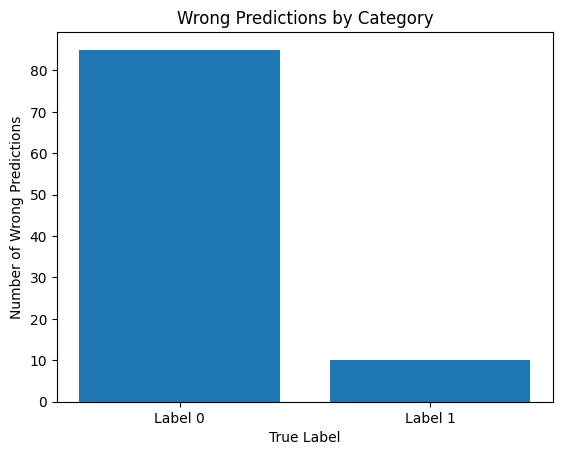

In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator_retriever(dfdem, 10, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]], retriever_type=1)
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluation Metrics: {'accuracy': 0.6766666666666666, 'fail_ratio': 0.0}
Time spent: 11.089014406998952
Indices of wrong predictions: [0, 3, 5, 6, 8, 10, 12, 15, 26, 27, 32, 37, 43, 44, 47, 48, 52, 53, 54, 58, 59, 61, 62, 64, 67, 71, 74, 80, 84, 89, 90, 91, 93, 94, 97, 100, 102, 111, 114, 117, 119, 120, 121, 122, 123, 133, 137, 138, 140, 141, 146, 149, 152, 159, 162, 167, 168, 171, 173, 175, 177, 178, 186, 187, 192, 193, 199, 205, 206, 207, 211, 215, 216, 219, 224, 229, 231, 232, 236, 245, 246, 248, 253, 254, 255, 257, 262, 265, 269, 270, 274, 277, 278, 291, 295, 297, 298]


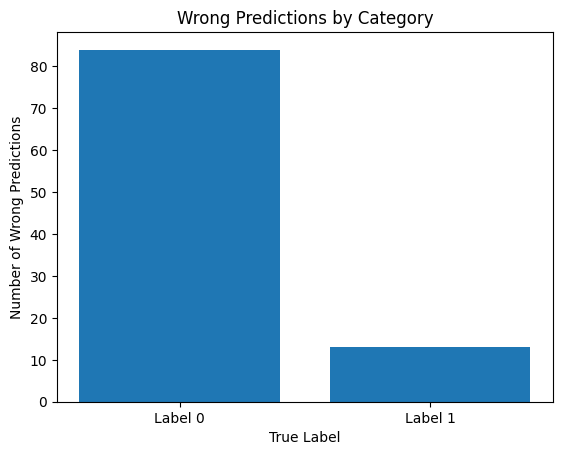

In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator_retriever(dfdem, 10, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]], retriever_type=2)
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

Evaluation Metrics: {'accuracy': 0.6966666666666667, 'fail_ratio': 0.0}
Time spent: 41.97639130751292
Indices of wrong predictions: [3, 6, 8, 10, 15, 18, 29, 32, 34, 44, 48, 52, 53, 54, 58, 59, 60, 61, 64, 67, 71, 74, 85, 89, 90, 91, 94, 97, 100, 102, 107, 114, 117, 120, 121, 122, 123, 124, 137, 138, 140, 141, 143, 146, 149, 152, 154, 158, 159, 168, 170, 171, 177, 186, 187, 190, 191, 192, 193, 203, 205, 206, 211, 215, 219, 220, 224, 226, 229, 231, 232, 236, 245, 249, 252, 253, 255, 257, 259, 262, 265, 269, 270, 274, 277, 278, 282, 285, 295, 297, 298]


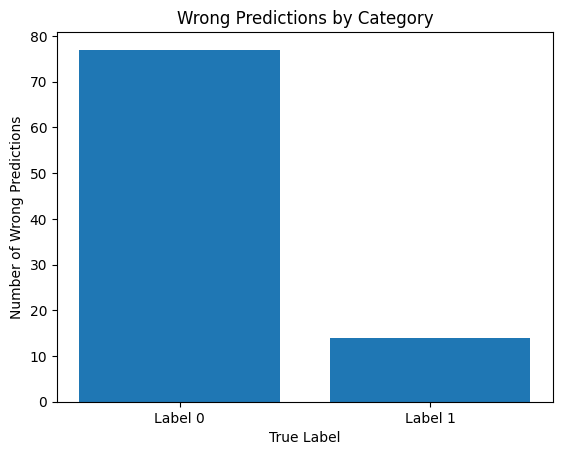

In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator_retriever(dfdem, 10, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]], retriever_type=3)
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

### experiments on llama:
#### 2 example injection since it was best based on previous experiments

Evaluation Metrics: {'accuracy': 0.56, 'fail_ratio': 0.0}
time spent: 4.646916282176972
Indices of wrong predictions: [0, 2, 3, 6, 7, 8, 10, 14, 17, 23, 24, 26, 27, 29, 32, 34, 38, 39, 44, 47, 48, 52, 53, 54, 57, 58, 60, 61, 62, 64, 65, 67, 71, 72, 74, 80, 81, 84, 85, 90, 91, 93, 94, 97, 100, 101, 102, 104, 107, 108, 111, 114, 117, 120, 121, 122, 123, 125, 126, 130, 136, 137, 138, 141, 143, 146, 147, 149, 152, 158, 159, 161, 162, 164, 168, 171, 172, 173, 177, 178, 179, 181, 186, 187, 190, 191, 192, 193, 195, 196, 199, 200, 205, 206, 207, 209, 211, 212, 215, 216, 219, 224, 226, 229, 231, 232, 233, 235, 236, 242, 248, 253, 254, 255, 257, 262, 265, 270, 274, 276, 277, 278, 281, 282, 283, 285, 286, 292, 294, 295, 297, 298]


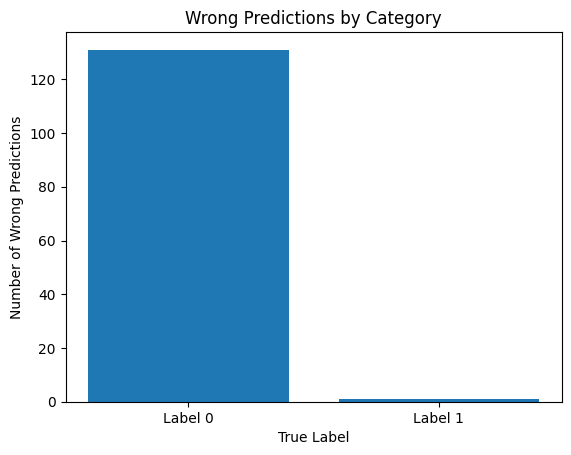

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator_retriever(dfdem, 2, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]], retriever_type=1)
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

Evaluation Metrics: {'accuracy': 0.56, 'fail_ratio': 0.0}
time spent: 6.527888794740041
Indices of wrong predictions: [0, 2, 3, 6, 7, 10, 14, 15, 17, 23, 24, 26, 27, 29, 32, 34, 38, 39, 44, 47, 48, 51, 52, 53, 54, 57, 58, 60, 61, 62, 64, 65, 67, 71, 72, 74, 80, 81, 84, 85, 90, 91, 93, 94, 97, 100, 101, 102, 107, 108, 111, 114, 117, 120, 121, 122, 123, 125, 126, 130, 133, 136, 137, 138, 141, 143, 146, 147, 149, 152, 158, 159, 161, 162, 164, 168, 171, 172, 173, 177, 178, 179, 186, 187, 190, 191, 192, 193, 195, 196, 199, 200, 205, 206, 207, 209, 211, 212, 215, 216, 219, 224, 226, 229, 231, 232, 233, 236, 242, 248, 253, 254, 255, 257, 262, 265, 270, 274, 276, 277, 278, 281, 282, 283, 285, 286, 292, 294, 295, 296, 297, 298]


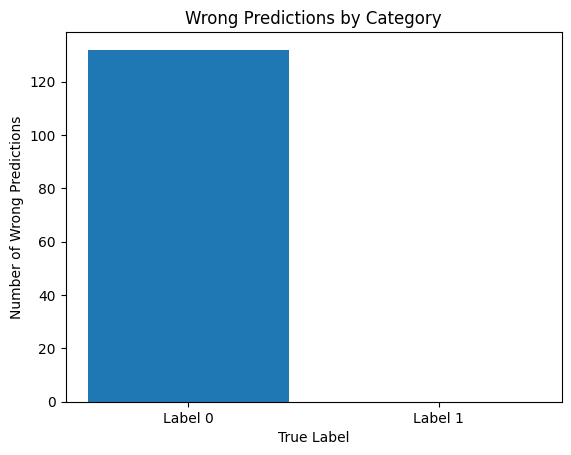

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator_retriever(dfdem, 2, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]], retriever_type=2)
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

Evaluation Metrics: {'accuracy': 0.5833333333333334, 'fail_ratio': 0.0}
time spent: 36.160591153303784
Indices of wrong predictions: [2, 3, 6, 7, 10, 14, 15, 17, 23, 26, 32, 34, 39, 44, 47, 48, 51, 52, 53, 54, 57, 58, 60, 61, 62, 64, 65, 67, 71, 72, 74, 80, 81, 84, 85, 89, 90, 91, 93, 94, 97, 100, 101, 102, 107, 108, 111, 114, 117, 120, 121, 122, 123, 125, 126, 130, 133, 137, 138, 141, 143, 146, 147, 149, 152, 158, 159, 161, 162, 164, 168, 171, 172, 173, 177, 178, 179, 181, 186, 187, 190, 191, 192, 193, 195, 196, 199, 200, 205, 206, 207, 209, 211, 215, 216, 219, 224, 226, 229, 231, 232, 233, 235, 236, 242, 248, 253, 254, 255, 257, 262, 265, 270, 274, 276, 277, 278, 281, 282, 283, 294, 295, 296, 297, 298]


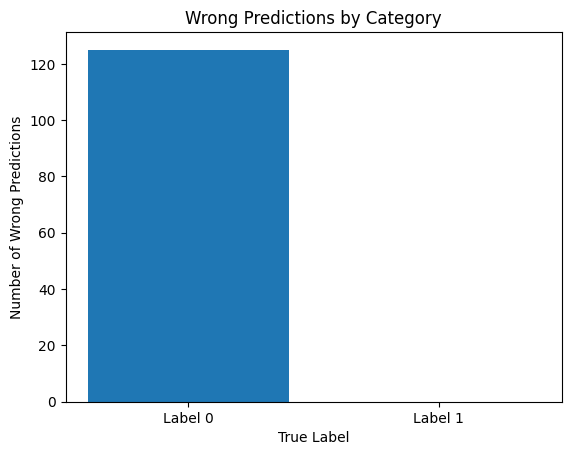

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator_retriever(dfdem, 2, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]], retriever_type=3)
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

### experiments on phi:
#### 2 example injection since it was best based on previous experiments

Evaluation Metrics: {'accuracy': 0.6433333333333333, 'fail_ratio': 0.0}
time spent: 3.4785702268282575
Indices of wrong predictions: [2, 3, 6, 8, 14, 17, 23, 24, 27, 34, 38, 39, 44, 48, 52, 53, 58, 59, 60, 61, 62, 64, 71, 74, 75, 78, 80, 85, 86, 90, 91, 93, 94, 97, 98, 100, 102, 107, 114, 117, 121, 122, 123, 124, 126, 130, 133, 137, 138, 141, 142, 143, 144, 146, 147, 149, 152, 154, 158, 159, 161, 168, 171, 173, 177, 178, 179, 186, 190, 192, 193, 196, 197, 200, 205, 206, 209, 210, 211, 212, 215, 219, 224, 226, 227, 229, 231, 232, 236, 246, 248, 252, 253, 255, 257, 262, 270, 271, 277, 281, 282, 289, 292, 294, 295, 297, 298]


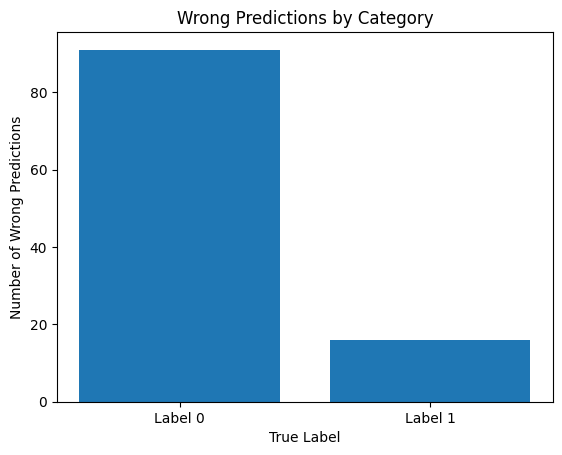

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator_retriever(dfdem, 2, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]], retriever_type=1)
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

Evaluation Metrics: {'accuracy': 0.6266666666666667, 'fail_ratio': 0.0}
time spent: 5.453678290049235
Indices of wrong predictions: [2, 3, 5, 6, 7, 8, 10, 14, 17, 27, 34, 38, 39, 44, 46, 47, 48, 50, 52, 53, 58, 61, 62, 64, 71, 74, 75, 78, 80, 85, 90, 91, 93, 97, 100, 102, 107, 108, 111, 114, 117, 120, 121, 122, 123, 125, 126, 130, 133, 136, 137, 138, 141, 142, 143, 144, 146, 149, 152, 158, 159, 161, 167, 168, 171, 173, 177, 178, 179, 186, 187, 190, 192, 193, 195, 197, 200, 205, 206, 209, 210, 211, 212, 215, 216, 219, 224, 226, 231, 232, 233, 235, 236, 246, 248, 249, 253, 255, 257, 262, 265, 270, 271, 277, 281, 282, 283, 292, 294, 295, 297, 298]


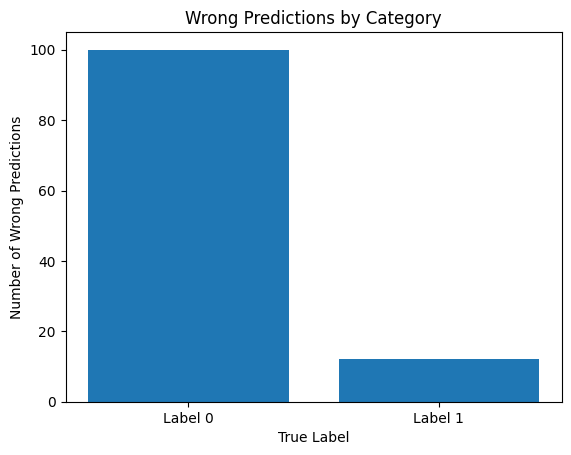

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator_retriever(dfdem, 2, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]], retriever_type=2)
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

Evaluation Metrics: {'accuracy': 0.66, 'fail_ratio': 0.0}
time spent: 33.744141411781314
Indices of wrong predictions: [2, 3, 6, 8, 10, 14, 17, 27, 34, 38, 39, 44, 45, 48, 50, 52, 53, 58, 61, 62, 64, 71, 74, 75, 80, 85, 90, 91, 93, 94, 97, 102, 107, 111, 114, 117, 120, 121, 122, 123, 125, 126, 130, 133, 134, 137, 140, 141, 143, 144, 146, 147, 149, 152, 159, 168, 171, 177, 178, 179, 186, 187, 190, 192, 193, 195, 197, 200, 201, 205, 206, 210, 211, 212, 215, 219, 224, 226, 229, 231, 232, 233, 236, 245, 246, 248, 249, 253, 254, 255, 257, 262, 270, 277, 282, 283, 284, 289, 292, 294, 295, 297]


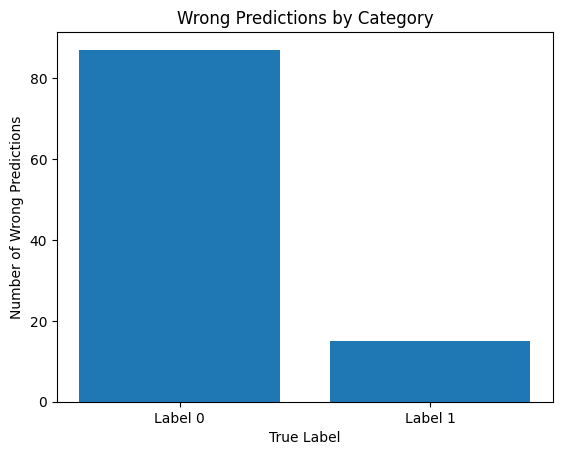

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa2.iterrows():
    predictions = few_evaluator_retriever(dfdem, 2, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]], retriever_type=3)
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

## Table of Contents

- [Section 1: Zero shot inference](#cell-Bs8GNXS5ukzf)
- [Section 2: Few shot inference](#cell-9-vNLs8Vkfci)
- [Section 3: Related-example selection](#cell-S2k-8YErxHjm)
- [Section 4: More Error analysis](#cell-p1JrEjDluWpH)
  - [4.1: **Full Explainations on Error analysis**](#cell-a8XYa9r-TeLc)
- [Section 5: Cut tokenization overhead](#cell-cELyQNNDz4Lm)
- [Section 6: Ensemble Model](#cell-0rEcrKWh1kOi)
- [Section 7: Test on A1 dataset](#cell-0YMVGK3Y2XOW)
- [Section 8: Some more analyze with demonstration dataset as test](#cell-E1Bq2SdLlSCp)






## More Error analysis:

Test experiment; with different number of examples (2,4,6,...,14); on few shot inference mode; on 300 datapoints; feeding those datapoints in last tests which labeled wrong (more than others) to observe any improvements; on llama model

In [ ]:
# Select specific rows by row number
rows_to_select = [0, 2, 11, 12, 14, 15, 16, 1,3,4,5,17, 22, 29, 6,7,8,9]  # Select the first and third row
print(dfdem.iloc[rows_to_select])



                   rewire_id  \
0   sexism2022_english-10348   
2    sexism2022_english-7742   
11  sexism2022_english-14973   
12  sexism2022_english-15291   
14   sexism2022_english-1157   
15   sexism2022_english-5118   
16  sexism2022_english-10398   
1    sexism2022_english-7950   
3   sexism2022_english-16170   
4    sexism2022_english-9857   
5   sexism2022_english-13335   
17   sexism2022_english-5236   
22   sexism2022_english-9749   
29  sexism2022_english-16712   
6    sexism2022_english-9829   
7    sexism2022_english-3499   
8   sexism2022_english-14446   
9   sexism2022_english-11508   

                                                 text  label_sexist  
0   I would never have my kid go to a daycare with...             0  
2   If you really wanted to twist the knife you’d ...             0  
11  She says this is not normal. Where has she bee...             0  
12  Are those bullets on her head necessary? Won't...             0  
14  Not all interactions with women have 

Evaluation Metrics: {'accuracy': 0.67, 'fail_ratio': 0.0}
time spent: 1.3887738188107808
Evaluation Metrics: {'accuracy': 0.67, 'fail_ratio': 0.0}
time spent: 1.754821201165517
Evaluation Metrics: {'accuracy': 0.6766666666666666, 'fail_ratio': 0.0}
time spent: 1.9935019373893739
Evaluation Metrics: {'accuracy': 0.655, 'fail_ratio': 0.0}
time spent: 2.2232422629992166
Evaluation Metrics: {'accuracy': 0.658, 'fail_ratio': 0.0}
time spent: 2.3208423972129824
Evaluation Metrics: {'accuracy': 0.6533333333333333, 'fail_ratio': 0.0}
time spent: 2.7656364401181537
Evaluation Metrics: {'accuracy': 0.6457142857142857, 'fail_ratio': 0.0}
time spent: 2.962913918495178


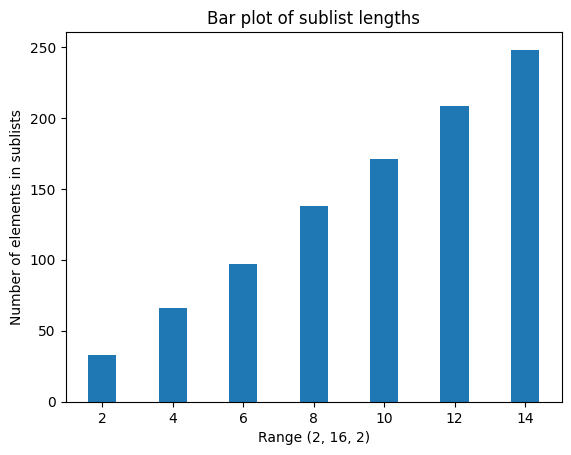

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []

wrongs = []
for num_exmp in range(2,16,2):
    start_time = time.time()
    for _, row in dfdem[30:130].iterrows():
        predictions = few_evaluator(dfdem.iloc[rows_to_select], num_exmp, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
        labels.append(row["label_sexist"])
        preds.extend(predictions)

    metrics_t, preds_la_few_t, labels_la_few_t = compute_metrics(preds, labels)
    print("Evaluation Metrics:", metrics_t)
    #print(compute_metrics(preds,labels))
    end_time = time.time()
    time_spent = (end_time - start_time)/60
    print("time spent: {}".format(time_spent))
    wrongs.append(wrong_counter(preds_la_few_t, labels_la_few_t))
import matplotlib.pyplot as plt

x_values = list(range(2, 16, 2))

# Get the number of elements in each sublist
y_values = [len(sublist) for sublist in wrongs]

# Create the bar plot
plt.bar(x_values, y_values)

# Add labels and title
plt.xlabel('Range (2, 16, 2)')
plt.ylabel('Number of elements in sublists')
plt.title('Bar plot of sublist lengths')

# Display the plot
plt.show()


Test experiment; with different number of examples (2,4,6,...,14); on few shot inference mode; on 100 datapoints; feeding those datapoints in last tests which labeled wrong (more than others) to observe any improvements; on phi-3 model

Evaluation Metrics: {'accuracy': 0.67, 'fail_ratio': 0.0}
time spent: 2.463511832555135
Evaluation Metrics: {'accuracy': 0.68, 'fail_ratio': 0.0}
time spent: 4.398133683204651
Evaluation Metrics: {'accuracy': 0.71, 'fail_ratio': 0.0}
time spent: 5.909573487440745
Evaluation Metrics: {'accuracy': 0.7325, 'fail_ratio': 0.0}
time spent: 7.741050744056702
Evaluation Metrics: {'accuracy': 0.736, 'fail_ratio': 0.0}
time spent: 9.586389521757761
Evaluation Metrics: {'accuracy': 0.7416666666666667, 'fail_ratio': 0.0}
time spent: 11.958100720246632
Evaluation Metrics: {'accuracy': 0.7485714285714286, 'fail_ratio': 0.0}
time spent: 14.459017590681713


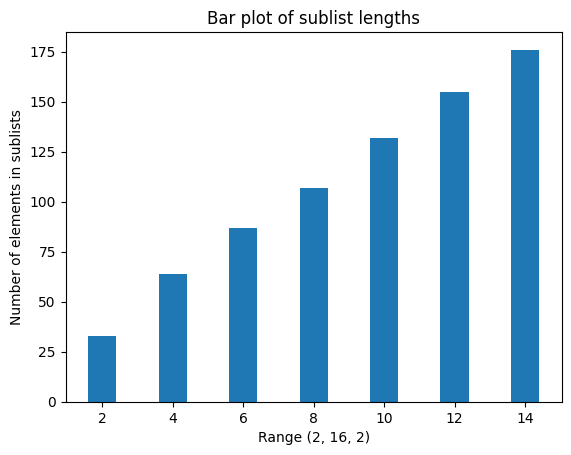

In [ ]:
rows_to_select_p = [0, 9, 12, 14, 16, 17, 20, 21, 22, 29, 30, 31, 1,2,3,4,5,6,7,8,10,11,13,15,18]
preds = []
labels = []
start_time = time.time()

wrongs2 = []
for num_exmp in range(2,16,2):
    for _, row in dfdem[30:130].iterrows():
        predictions = few_evaluator(dfdem.iloc[rows_to_select_p], num_exmp, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]])
        labels.append(row["label_sexist"])
        preds.extend(predictions)

    metrics_t, preds_phi_few_t, labels_phi_few_t = compute_metrics(preds, labels)
    print("Evaluation Metrics:", metrics_t)
    #print(compute_metrics(preds,labels))
    end_time = time.time()
    time_spent = (end_time - start_time)/60
    print("time spent: {}".format(time_spent))
    wrongs2.append(wrong_counter(preds_phi_few_t, labels_phi_few_t))
import matplotlib.pyplot as plt

x_values = list(range(2, 16, 2))

# Get the number of elements in each sublist
y_values = [len(sublist) for sublist in wrongs2]

# Create the bar plot
plt.bar(x_values, y_values)

# Add labels and title
plt.xlabel('Range (2, 16, 2)')
plt.ylabel('Number of elements in sublists')
plt.title('Bar plot of sublist lengths')

# Display the plot
plt.show()


Test experiment; with only 1 not-sexist example; on few shot inference mode

In [ ]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2, exm_mode=True):
    demonstrations = demonstrations.dropna(subset=['label_sexist'])

    examples = []
    labels = []

    if exm_mode:
        share = num_per_class#int(num_per_class / 2)
        for label, label_str in [(0, "NO")]:
            sampled_examples = demonstrations[demonstrations["label_sexist"] == label].sample(
                n=min(share, len(demonstrations[demonstrations["label_sexist"] == label])),
                random_state=42,
                replace=True
            )
            for _, row in sampled_examples.iterrows():
                examples.append(f"Text: {row['text']}\nANSWER: {label_str}")
    else:
        sampled = demonstrations.sample(n=min(num_per_class, len(demonstrations)), random_state=42, replace=True)
        for _, row in sampled.iterrows():
            examples.append(row["text"])
            labels.append(row["label_sexist"])

    return examples, labels

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem.iterrows():
    predictions = few_evaluator(dfdem, 1, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few2, labels_la_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))


Evaluation Metrics: {'accuracy': 0.635, 'fail_ratio': 0.0}
time spent: 12.968804534276327


Indices of wrong predictions: [0, 12, 15, 16, 17, 21, 22, 30, 31, 33, 40, 42, 44, 51, 56, 59, 61, 63, 65, 69, 72, 75, 76, 77, 78, 84, 87, 88, 91, 94, 95, 98, 99, 105, 106, 109, 110, 117, 120, 123, 129, 132, 139, 147, 152, 154, 156, 157, 159, 161, 162, 164, 165, 168, 169, 171, 172, 173, 174, 178, 179, 183, 185, 191, 192, 200, 201, 205, 206, 209, 214, 215, 216, 217, 219, 221, 223, 226, 234, 238, 240, 242, 243, 246, 247, 249, 255, 259, 260, 265, 270, 272, 275, 281, 282, 283, 287, 289, 292, 293, 294, 296, 298, 299, 300, 302, 303, 306, 310, 311, 313, 316, 317, 318, 319, 320, 322, 327, 333, 336, 337, 339, 340, 344, 346, 347, 354, 356, 359, 365, 369, 371, 377, 379, 382, 386, 388, 390, 391, 396, 398, 401, 402, 403, 405, 406, 407, 408, 410, 411, 412, 417, 418, 419, 420, 421, 422, 429, 431, 437, 439, 440, 444, 446, 450, 453, 456, 459, 462, 463, 474, 475, 476, 477, 479, 482, 486, 489, 491, 492, 495, 496, 497, 498, 499, 501, 504, 505, 506, 507, 508, 511, 512, 515, 516, 521, 522, 523, 524, 528, 530

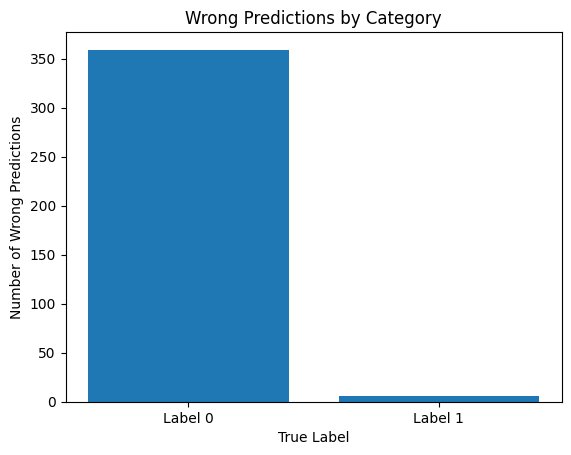

In [ ]:
analyze_wrong_predictions(preds_la_few2, labels_la_few2)

Test experiment; with only 8 example (4:4); on few shot inference mode; on first 80 datapoints of demonstration data

Evaluation Metrics: {'accuracy': 0.7125, 'fail_ratio': 0.0}
time spent: 1.8255709568659464
Indices of wrong predictions: [0, 11, 12, 15, 17, 22, 29, 30, 31, 40, 42, 44, 51, 56, 59, 61, 65, 67, 69, 75, 76, 77, 78]


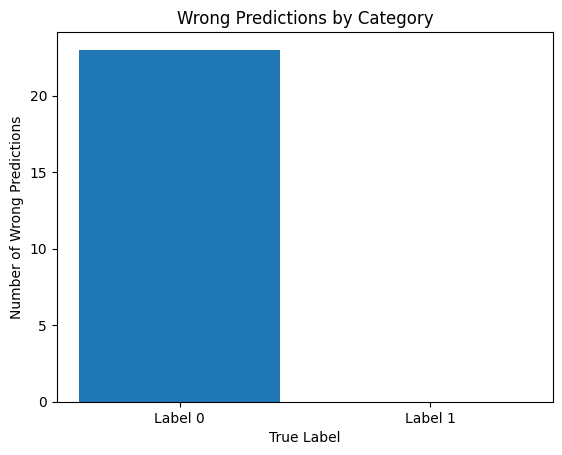

In [ ]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2, exm_mode=True):
    demonstrations = demonstrations.dropna(subset=['label_sexist'])

    examples = []
    labels = []

    if exm_mode:
        share = 4
        for label, label_str in [(0, "NO"), (1, "YES")]:

            sampled_examples = demonstrations[demonstrations["label_sexist"] == label].sample(
                n=min(share, len(demonstrations[demonstrations["label_sexist"] == label])),
                random_state=42,
                replace=True
            )
            share = 4

            for _, row in sampled_examples.iterrows():
                examples.append(f"Text: {row['text']}\nANSWER: {label_str}")
    else:
        sampled = demonstrations.sample(n=min(num_per_class, len(demonstrations)), random_state=42, replace=True)
        for _, row in sampled.iterrows():
            examples.append(row["text"])
            labels.append(row["label_sexist"])

    return examples, labels

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem[0:80].iterrows():
    predictions = few_evaluator(dfdem, 7, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few2, labels_la_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few2, labels_la_few2)

Test experiment; on simple inference mode (no example); on first 500 datapoints of demonstration data; with phi-3 model

{'accuracy': 0.626, 'fail_ratio': 0.0}
time spent: 21.24918087720871
Indices of wrong predictions: [0, 2, 12, 15, 16, 17, 30, 31, 33, 40, 42, 54, 56, 59, 61, 63, 65, 69, 75, 76, 77, 78, 85, 87, 88, 89, 90, 92, 95, 98, 99, 105, 109, 110, 112, 117, 120, 123, 129, 130, 132, 135, 139, 142, 146, 147, 152, 154, 156, 161, 162, 164, 165, 168, 169, 171, 172, 173, 174, 178, 179, 185, 186, 187, 189, 191, 199, 200, 201, 205, 206, 209, 212, 214, 215, 216, 219, 221, 223, 226, 232, 234, 236, 238, 240, 242, 243, 246, 247, 249, 255, 263, 265, 269, 270, 272, 275, 278, 281, 282, 283, 289, 293, 294, 296, 298, 299, 300, 302, 303, 305, 306, 313, 317, 318, 319, 320, 322, 327, 333, 336, 337, 339, 340, 344, 346, 347, 354, 356, 359, 362, 365, 366, 369, 371, 377, 379, 380, 382, 386, 388, 391, 392, 396, 400, 401, 402, 403, 405, 406, 407, 408, 410, 411, 412, 416, 417, 418, 419, 420, 421, 422, 427, 431, 434, 437, 439, 440, 453, 456, 463, 465, 471, 474, 475, 476, 477, 479, 482, 489, 491, 492, 495, 496, 497, 498, 499

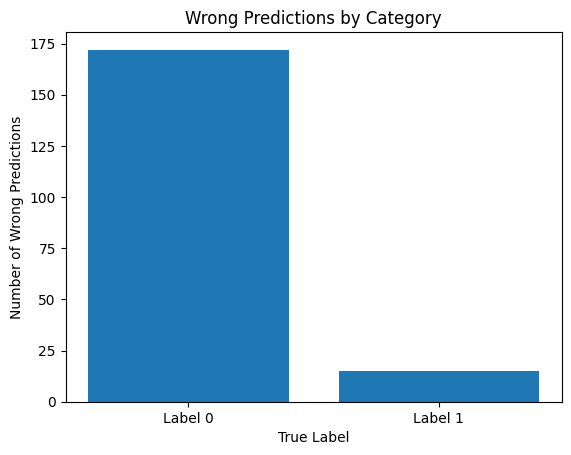

In [ ]:
#flag
import time
start_time = time.time()
preds_la_one_t, labels_la_one_t = evaluator(dfdem[0:500]["text"], dfdem[0:500]["label_sexist"], prompt_phi, tokenizer_phi, model, phi= True)
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))

analyze_wrong_predictions(preds_la_one_t, labels_la_one_t)

# Analysis of Model Performance with Few-shot Prompting

## 1. Observed Accuracy Patterns
The new results reveal important insights about the relationship between the number of examples and model accuracy.

| Model         | Example Ratio (Sexist : Not-Sexist) | Accuracy (%) (full dataset) | Time (minute) |
|---------------|-------------------------------------|-----------------------------|---------------|
| **LLaMA**     | 1:1                                 | 56                          | 4             |
| **LLaMA**     | 2:2                                 | 55                          | 5             |
| **LLaMA**     | 3:3                                 | 55                          | 5.8           |
| **Phi-3**     | 1:1                                 | 64                          | 7             |
| **Phi-3**     | 2:2                                 | 63                          | 8             |
| **Phi-3**     | 3:3                                 | 60                          | 10            |
| **mistral**   | 1:1                                 | 59                          | 6.5           |
| **mistral**   | 2:2                                 | 65                          | 7             |
| **mistral**   | 3:3                                 | 66                          | 9             |
| **mistral**   | 5:5                                 | 70                          | 9.5           |
| **mistral**   | 7:7                                 | 71                          | 11            |
| **mistral**   | 10:10                                 | 70                          | 15            |

- Phi-3 and LLaMA:

  - Accuracy decreases as the number of examples in the prompt increases.
  - Suggests sensitivity to larger or noisier prompts.
- Mistral:

  - Accuracy improves with more examples, peaking at a 7:7 ratio.
  - Declines slightly beyond this, indicating oversaturation of the prompt.
- General Trend:
  - Randomly adding examples does not consistently improve accuracy. Prompt quality, structure, and model capacity are critical.


**Key Insight:**  
- Model-Specific Trends:

  - Phi-3 and LLaMA struggle with longer prompts, potentially due to noise or limited capacity for additional context.
  - Mistral effectively utilizes more examples but reaches a saturation point.
- Quality Over Quantity:

  - Randomly increasing examples can reduce accuracy. High-quality, curated examples are crucial for performance.
- Future Directions:

  - Investigate systematic example selection (e.g., clustering, diversity sampling).
  - Explore prompt optimization tailored to each model's strengths.

---

## 2. Few-shot Example Distribution Impact
a) Few-shot inference on 300 data points:
We ran few-shot inference on 100 data points, gradually increasing the number of balanced examples from 2 to 14. We also used indices that were misclassified in the initial runs (for LLaMA, we specifically used incorrect indices from the 2:2 configuration) and injected them primarily as examples. The result was a gradual increase in the number of incorrect predictions as the number of examples increased. This shows that complicating the examples leads to worse results, either due to a more complex prompt or due to overfitting.

b) Experimenting with different example distributions:
Since we observed significant imbalance in misclassifications across categories, our second experiment tested different distributions of examples. When experimenting with different ratios of sexist (1) and not-sexist (0) examples on the first 80 data points of our dataset, the results were as follows:

| Ratio (Not-Sexist : Sexist)   | 2:2  | 5:5  | 6:4  | 7:3  | 3:3  | 3:1  | 7:1  | 3:2  | 6:1  | 8:2  | 4:1  | 4:4  | 2:0  | 9:1  | 4:3  | 1:3  |
|-------------------------------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
| **Accuracy (%)** (80 datapoints) | 78   | 77   | 76   | 73   | 75   | 75   | 75   | 73   | 75   | 72   | 72   | 71   | 70   | 67   | 67   | 65   |


### Observations:
- **Balanced examples** (e.g., 2:2, 5:5) yield the highest accuracy (77–78%), suggesting that balanced datasets provide the best context for models to generalize.
- **Dominance of not-sexist examples** (e.g., 6:1, 9:1) led to moderate-to-poor performance, showing model bias toward the majority class.
- **Pure sexist example dominance** (e.g., 1:3) severely degraded accuracy, dropping to 65%.

---

## 3. related-example extracting

| Model       | TF-IDF | word2vec | Bert based | previous result with same number of examples |
|-------------|--------|------------|----------|---------------|
| **mistral**(7:7) | 68% (9min) | 67% (11min) | 69% (41min)  | 70% (9min) |
| **LLaMA**(1:1)   | 56% (4min) | 56% (6min)  | 58% (36min)  | 56%(4min)  |
| **Phi-3**(1:1)   | 64% (3min) | 62% (5min)  | 66% (33min)  | 64% (7min) |
| **average** | 62% (5min) | 61% (7min)  | 64% (36min)  | 63% (6min) |

**Observations**

#####BERT-based Selection:
- Improved accuracy for **LLaMA** (+2%) and **Phi-3** (+2%) but not for **Mistral**.
- Comes at a significant time cost, with the process being **5–9x slower** than other methods due to computational demands of tokenizing and example selection.

#####TF-IDF Selection:
- No accuracy improvement but provides **time optimization**, making it a pragmatic choice when speed is critical.

#####Word2Vec Selection:
- Failed to improve either **accuracy** or **time**, making it the least effective method in this experiment.

**Key Insights**

#####Trade-off Between Accuracy and Speed:
- **BERT-based selection** can improve accuracy but is computationally expensive.
- **TF-IDF** offers a balance for scenarios prioritizing speed over small accuracy gains.

#####Model-Specific Trends:
- **Mistral**: Accuracy declined with BERT-based selection, suggesting it may not benefit from more complex example injection.
- **LLaMA** and **Phi-3**: Accuracy improved with BERT-based selection, indicating sensitivity to well-selected examples.

#####General Finding:
- Intelligent example selection can potentially optimize **accuracy** or **time** but rarely both simultaneously.

#####Conclusion
- **Targeted example selection** based on relevance (e.g., using **BERT embeddings**) shows promise for improving accuracy but demands significantly more resources.
- **TF-IDF** emerges as a practical alternative for optimizing time without sacrificing performance.
- Balancing **accuracy gains** and **time cost** is key for practical applications.

---
## 3.2 models characterestic analysis
##### **Varying Response to Prompt Length**
  - Mistral: Gains accuracy with more examples up to a saturation point. This aligns with its design to handle longer contexts more efficiently (e.g., FlashAttention, multi-query attention). Once “overfed” with examples (e.g., beyond 7:7), performance dips slightly—likely because the excess context dilutes clarity instead of adding value.

  - LLaMA & Phi-3: Both show reduced accuracy as prompt size grows beyond a minimal set. This suggests they are more sensitive to “prompt noise” or have a smaller effective context window. Additional examples may compete for attention without yielding clearer patterns.

##### **Example Selection Trade-offs (TF-IDF, Word2Vec, BERT)**
  - BERT-based selection generally boosted accuracy for LLaMA and Phi-3 but not for Mistral, possibly because:

    - LLaMA & Phi-3 respond well to “cleaner”, more semantically precise examples.
    - Mistral already handles context robustly, and the heavier selection method doesn’t add enough incremental clarity to offset the overhead.
  - TF-IDF offers speed with no significant accuracy gain/loss—a pragmatic choice where minimal overhead is desired.

  - Word2Vec neither improved accuracy nor speed, implying it’s less relevant for modern Transformer-based LLM prompts.

##### **Model-Specific Architecture Nuances**

- Mistral (v0.3, ~7B)

  - GPT-like but optimized with FlashAttention, possibly making it more capable of leveraging multiple examples efficiently.
  - Behaviorally “BERT-like” in embedding structure (i.e., contextual, learned end-to-end) yet different from static Word2Vec or sparse TF-IDF.
- LLaMA-3.1 (~8B)

  - RoPE embeddings, multi-head attention typical of LLaMA lineage.
  - Potentially sensitive to prompt length if not carefully curated, as the original LLaMA was known for strong performance but also for being context-sensitive.

- Phi-3.5-mini (~3.5B)

  - Smaller GPT-style model, likely with a reduced parameter count vs. LLaMA or Mistral.
  - Gains from carefully curated examples but struggles if the context grows too large or is noisy—common in smaller Transformer-based models.


---

## 4. Analysis of Execution Time

Execution Speed:

- LLaMA runs faster than Phi-3 for smaller example ratios, but the gap narrows with increased examples.

  - At a 1:1 ratio, LLaMA completes in 4 minutes, while Phi-3 takes 7 minutes.
  - At a 3:3 ratio, LLaMA takes 5.8 minutes, while Phi-3 takes 10 minutes, showing both models experience an increase in processing time with added examples.
- Mistral exhibits competitive timing and scales well with increased examples.

  - At a 1:1 ratio, Mistral takes 6.5 minutes, slightly slower than LLaMA.
  - At higher ratios, such as 10:10, Mistral completes in 15 minutes, balancing scalability with accuracy gains.
- Key Time-Accuracy Trade-offs:

  - LLaMA is faster but shows limited accuracy gains with additional examples.
  - Phi-3 achieves higher accuracy than LLaMA but incurs a higher time cost, especially with larger prompts.
  - Mistral offers a middle ground, with better accuracy and manageable execution time but a bit more time consuming, particularly for example ratios up to 7:7.

## 5. Bias Toward the Not-Sexist Class

### Overview of Class Imbalance:
Across all configurations, the model shows a clear bias toward predicting the "not-sexist" class. This is evident from the higher rate of misclassifications for not-sexist examples compared to sexist ones:

- **Misclassifications for "Not-Sexist" texts:**  
  - Approximately **250–400** wrong predictions.
  
- **Misclassifications for "Sexist" texts:**  
  - Approximately **10–60** wrong predictions.

### Impact of Class Imbalance in Few-shot Prompting:
When we introduced more not-sexist examples during few-shot prompting (e.g., using a 6:1 ratio), the class imbalance bias worsened. This resulted in an increased number of incorrect "not-sexist" predictions.

---

### Underlying Causes:

1. **Class Imbalance in Training Data:**
   - Pre-trained models may have been exposed to less neutral or toxic content, causing them to default to labeling new inputs as "sexist" more frequently.
   
2. **Overfitting to Prompt Examples:**
   - When not-sexist examples dominate the few-shot prompts, the model tends to assume that subsequent inputs follow a similar trend. This leads to **overfitting**, where the model becomes too focused on the problematic class (not-sexist) and struggles to generalize for other examples.
   
---

### Key Insight:
The combination of class imbalance in training data probably significantly impacts model performance, leading to a **bias toward the not-sexist class**.

---
## 6. Token Context Window and Input Size (guess)

### Key Observations:
Our experiment highlights the following patterns regarding token context window limits and input size:

- **Few-shot inference:**  
  - As more examples are added to the prompt, accuracy improves initially but **declines** after a certain point.
  - This behavior aligns with the **token context window limit** of the models.

---

### Token Context Window for LLaMA and Phi-3 Models:
- Both **LLaMA** and **Phi-3** models have a **2048-token** context window by default.
  
- **Impact of Prompt Size:**
  - As the number of examples or the verbosity of formatting increases, the total prompt length approaches or exceeds the **2048-token limit**.
  - When this happens:
    - **Prompt Truncation**: Earlier parts of the prompt (including examples) may get **truncated**.
    - **Comprehension Challenges**: The model struggles to effectively balance understanding both the examples and the query within the token limit.


---
so we try to test the last guess




In [ ]:
def prepare_prompts_few_n(exmps, texts, prompt_template, tokenizer, phi=True):
    if isinstance(prompt_template, list):  # If template is list-based (chat format)
        prompt_template_str = prompt_template[1]['content']
    else:
        prompt_template_str = prompt_template

    # Format examples
    examples_str = "\n\n".join(exmps)

    # Combine examples and texts into prompts
    prompts = [
        prompt_template_str.format(examples=examples_str, text=text)
        for text in texts
    ]
    # Tokenize all prompts
    return [
        tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to('cuda')
        for prompt in prompts
    ]

# Build 10 examples (5 sexist, 5 not-sexist)
num_examples = 10
few_shot_examples, _ = build_few_shot_demonstrations(dfdem, num_per_class=num_examples)

# Construct a test text (can be any placeholder text)
test_text = "This is a test input text to evaluate token count with 10 examples."

# Prepare a single prompt with the few-shot examples
tokenized_prompt = prepare_prompts_few_n(few_shot_examples, [test_text], prompt_few, tokenizer_phi, phi=True)

# Count the tokens
def count_tokens_in_prompt(tokenized_prompt):
    """
    Counts the number of tokens in a tokenized prompt.
    """
    return tokenized_prompt['input_ids'].shape[1]  # input_ids: (batch_size, seq_len)

# Log token count
token_count = count_tokens_in_prompt(tokenized_prompt[0])  # Single prompt
print(f"Token count for a prompt with {num_examples} examples: {token_count}")


Token count for a prompt with 10 examples: 525


## Rejection of the Context Window Hypothesis

### Context Window Limit Consideration:
The context window hypothesis is **rejected** for the following reasons:

- **Prompt Length:**  
  - The prompt length at **435 tokens** (for llama) **525 tokens** (for phi) is well within the **2048-token** context limit of both the **LLaMA** and **Phi-3** models.
  
- **Accuracy Decline:**  
  - Despite the prompt being well within the token limit, accuracy still declines. This suggests that the issue is not related to the **context window limit**.

---

### Likely Causes of Accuracy Decline:
The accuracy decline is likely due to the following factors:

 **Example Saturation:**
   - As more examples are added to the prompt, the model may become **overfit** to these examples, reducing its ability to generalize to new queries.

---

### Key Insight:
The decline in accuracy is not due to the context window limit. Instead, it seems to stem from **overfitting** to the examples.


## Table of Contents

- [Section 1: Zero shot inference](#cell-Bs8GNXS5ukzf)
- [Section 2: Few shot inference](#cell-9-vNLs8Vkfci)
- [Section 3: Related-example selection](#cell-S2k-8YErxHjm)
- [Section 4: More Error analysis](#cell-p1JrEjDluWpH)
  - [4.1: **Full Explainations on Error analysis**](#cell-a8XYa9r-TeLc)
- [Section 5: Cut tokenization overhead](#cell-cELyQNNDz4Lm)
- [Section 6: Ensemble Model](#cell-0rEcrKWh1kOi)
- [Section 7: Test on A1 dataset](#cell-0YMVGK3Y2XOW)
- [Section 8: Some more analyze with demonstration dataset as test](#cell-E1Bq2SdLlSCp)






## Cut tokenization overhead

### in another experiment we though by cutting the Tokenization Overhead we can reduce the time consumption
#### the reason behind this was Tokenizing repeatedly for the same examples can increases computational cost.

In [ ]:
def few_evaluator(data, num_exmp, tokenizer, model, prompt_template, text, labels, phi=True, key="ANSWER"):
    # Build few-shot examples
    examples, _ = build_few_shot_demonstrations(data, num_exmp)

    # Cache tokenized few-shot examples
    cached_examples = prepare_prompts_few(examples, [""], prompt_template, tokenizer, phi=phi)

    # Tokenize new inputs using the cached examples
    tokenized_prompts = fast_prepare_prompts(cached_examples, text, tokenizer)

    # Generate responses
    responses = generate_responses(model, tokenized_prompts, tokenizer)
    #print("respons is: {}".format(responses))

    # Process responses into binary predictions
    predictions = []
    for response in responses:
        answer = split_string(response, key=key)
        predictions.append(process_response(answer))

    return predictions



def fast_prepare_prompts(cached_examples, texts, tokenizer):
    prompts = []
    for cached_example, text in zip(cached_examples, texts):
        # Decode cached examples back into text (if necessary)
        cached_text = tokenizer.decode(cached_example['input_ids'].squeeze(), skip_special_tokens=True)

        # Append new input text with proper formatting
        new_prompt = f"{cached_text}\n\nTEXT:\n{text}\n\nANSWER:"

        # Tokenize the combined prompt
        tokenized_prompt = tokenizer(new_prompt, return_tensors='pt', padding=True, truncation=True).to('cuda')
        prompts.append(tokenized_prompt)

    return prompts



# Running the fixed evaluator
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem[0:10].iterrows():
    predictions = few_evaluator(dfdem, 4, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")


Evaluation Metrics: {'accuracy': 0.2, 'fail_ratio': 0.0}
Time spent: 1.2042866071065268


Indices of wrong predictions: [4, 5, 7]


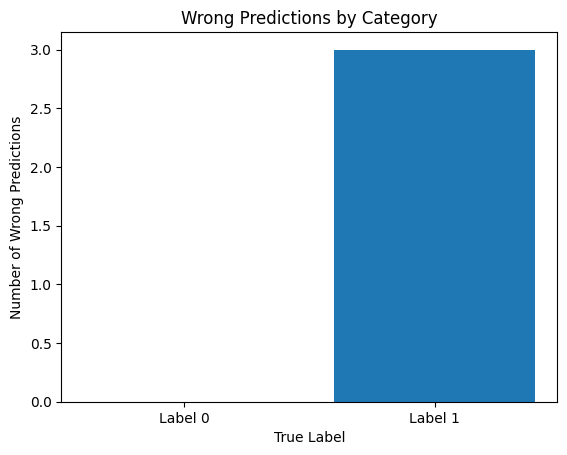

In [ ]:
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)


In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfdem[0:30].iterrows():
    predictions = few_evaluator(dfdem, 4, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")


Evaluation Metrics: {'accuracy': 0.8, 'fail_ratio': 0.0}
Time spent: 0.6359629511833191


##### the two result above were only tests to understand if our method works fine
##### surprizingly we found out by having 2 examples the approach dont work correctly at all
##### but injecting 4 examples lead to more normal answers
##### hence we test this approach with 4 number of examples on whole demonstration dataset

In [ ]:
import time


preds = []
labels = []
start_time = time.time()

for _, row in dfdem.iterrows():
    predictions = few_evaluator(dfdem, 4, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

# Compute metrics
metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")


Evaluation Metrics: {'accuracy': 0.7, 'fail_ratio': 0.0}
Time spent: 22.084736824035645


### the result shows that this method decrease the accuracy by 1% and also increase the time consumption which is not what we wanted at all :(

## Table of Contents

- [Section 1: Zero shot inference](#cell-Bs8GNXS5ukzf)
- [Section 2: Few shot inference](#cell-9-vNLs8Vkfci)
- [Section 3: Related-example selection](#cell-S2k-8YErxHjm)
- [Section 4: More Error analysis](#cell-p1JrEjDluWpH)
- [Section 5: Cut tokenization overhead](#cell-cELyQNNDz4Lm)
- [Section 6: Ensemble Model](#cell-0rEcrKWh1kOi)
- [Section 7: Test on A1 dataset](#cell-0YMVGK3Y2XOW)
- [Section 8: Some more analyze with demonstration dataset as test](#cell-E1Bq2SdLlSCp)






## ensemble modeling

We had a guess that maybe using the result of 3 models together can increase the accuracy
sort of voting model
however, results shows the opposite

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Combine Models and Tokenizers
models = [model_mistral, model_llama, model]
tokenizers = [tokenizer_mistral, tokenizer_llama, tokenizer_phi]

def train_meta_ensemble(models, tokenizers, data, num, prompt_template):
    # Collect training data for meta-model
    meta_features = []
    meta_labels = []
    #few_shot_examples, _ = build_few_shot_demonstrations(data, num_exmp)

    for text, label in zip(data["text"], data["label_sexist"]):
        features = []
        for model, tokenizer, phiB, num_exmp in zip(models, tokenizers, [True, True, True], [10,4,4]):
            predictions = few_evaluator(data, num_exmp, tokenizer, model, prompt_template, [text], [label], phi=phiB)
            features.append(predictions[0])  # Append prediction for this model
        meta_features.append(features)
        meta_labels.append(label)

    # Train meta-classifier
    meta_model = LogisticRegression()
    meta_model.fit(meta_features, meta_labels)
    return meta_model

meta_model = train_meta_ensemble(models, tokenizers, dfdem, 4, prompt_few)

In [ ]:
def meta_ensemble_few_evaluator(meta_model, models, tokenizers, data, num, prompt_template, text, labels, key="ANSWER"):
    #few_shot_examples, _ = build_few_shot_demonstrations(data, num_exmp)
    meta_features = []

    for text_item in text:
        features = []
        for model, tokenizer, phiB, num_exmp in zip(models, tokenizers, [True, True, True], [10,4,4]):
            predictions = few_evaluator(data, num_exmp, tokenizer, model, prompt_template, [text_item], [0], phi=phiB, key=key)
            features.append(predictions[0])
        meta_features.append(features)

    # Use meta-classifier for final predictions
    final_predictions = meta_model.predict(meta_features)
    metrics, _, _ = compute_metrics(final_predictions, labels)
    #print(f"Meta-Ensemble Metrics: {metrics}")
    return final_predictions, labels

preds = []
labels = []

start_time = time.time()

# Iterate over the DataFrame rows
for _, row in dfa2.iterrows():

    predictions, true_labels = meta_ensemble_few_evaluator(
        meta_model=meta_model,
        models=models,
        tokenizers=tokenizers,
        data=dfdem,
        num=4,  # Number of few-shot examples
        prompt_template=prompt_few,  # Replace with your prompt template
        text=[row["text"]],  # Input text
        labels=[row["label_sexist"]],  # True labels
        key="ANSWER"  # Key for splitting responses
    )
    preds.extend(predictions)
    labels.extend(true_labels)

# Compute and print final metrics
metrics, preds_final, labels_final = compute_metrics(preds, labels)
print("Final Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")

Final Evaluation Metrics: {'accuracy': 0.71, 'fail_ratio': 0.0}
Time spent: 23.587759109338126


## Table of Contents

- [Section 1: Zero shot inference](#cell-Bs8GNXS5ukzf)
- [Section 2: Few shot inference](#cell-9-vNLs8Vkfci)
- [Section 3: Related-example selection](#cell-S2k-8YErxHjm)
- [Section 4: More Error analysis](#cell-p1JrEjDluWpH)
  - [4.1: **Full Explainations on Error analysis**](#cell-a8XYa9r-TeLc)
- [Section 5: Cut tokenization overhead](#cell-cELyQNNDz4Lm)
- [Section 6: Ensemble Model](#cell-0rEcrKWh1kOi)
- [Section 7: Test on A1 dataset](#cell-0YMVGK3Y2XOW)
- [Section 8: Some more analyze with demonstration dataset as test](#cell-E1Bq2SdLlSCp)






### Test against A1-test dataset

| Model         | Example Ratio (Sexist : Not-Sexist) | Accuracy (%) (full dataset) | Time (minute) |
|---------------|-------------------------------------|-----------------------------|---------------|
| **LLaMA**     | 1:1                                 | 60                          | 4           |
| **Phi-3**     | 1:1                                 | 75                          | 3             |
| **mistral**   | 7:7                                 | 77                          | 11            |


Evaluation Metrics: {'accuracy': 0.7587412587412588, 'fail_ratio': 0.0}
time spent: 3.7385504047075906
Indices of wrong predictions: [6, 9, 13, 18, 20, 24, 26, 29, 30, 39, 40, 42, 47, 50, 56, 59, 61, 62, 69, 72, 76, 82, 86, 88, 91, 92, 95, 99, 109, 110, 113, 118, 124, 136, 140, 149, 151, 152, 155, 158, 161, 167, 171, 173, 174, 182, 189, 190, 191, 195, 212, 214, 220, 223, 226, 228, 231, 233, 234, 235, 239, 244, 248, 261, 263, 265, 268, 277, 279]


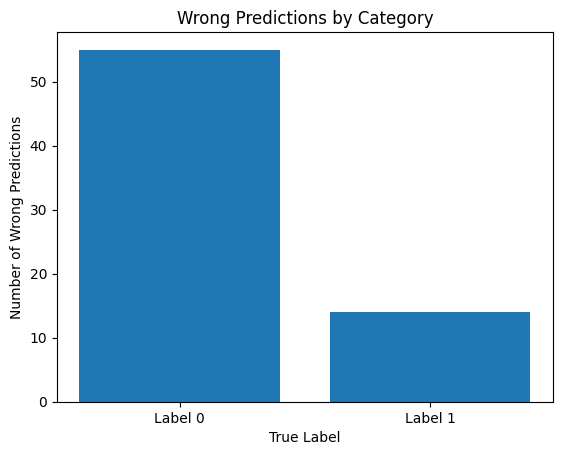

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa1.iterrows():
    predictions = few_evaluator(dfdem, 2, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluation Metrics: {'accuracy': 0.7727272727272727, 'fail_ratio': 0.0}
time spent: 11.033781619866689
Indices of wrong predictions: [7, 9, 11, 20, 24, 30, 31, 37, 40, 41, 42, 47, 48, 57, 61, 62, 64, 68, 69, 73, 74, 76, 81, 82, 86, 104, 106, 108, 109, 110, 112, 118, 121, 122, 123, 125, 135, 150, 151, 152, 155, 167, 171, 174, 179, 182, 191, 195, 197, 210, 211, 214, 219, 220, 226, 229, 232, 234, 244, 246, 252, 261, 263, 264, 277]


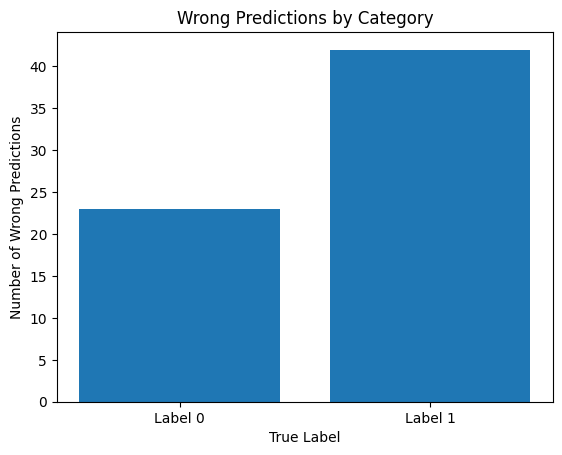

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa1.iterrows():
    predictions = few_evaluator(dfdem, 14, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

Evaluation Metrics: {'accuracy': 0.6048951048951049, 'fail_ratio': 0.0}
time spent: 3.9766084631284078
Indices of wrong predictions: [7, 9, 11, 12, 13, 14, 17, 18, 19, 20, 21, 24, 26, 30, 33, 35, 36, 39, 43, 44, 50, 56, 58, 59, 60, 61, 62, 71, 72, 74, 76, 80, 82, 88, 89, 90, 91, 92, 93, 94, 95, 97, 100, 103, 105, 107, 109, 110, 113, 116, 117, 118, 120, 124, 131, 133, 136, 137, 139, 140, 144, 149, 151, 153, 154, 158, 159, 161, 162, 166, 167, 171, 173, 174, 182, 189, 190, 191, 194, 199, 200, 201, 202, 205, 208, 212, 213, 215, 217, 223, 226, 228, 231, 233, 234, 235, 239, 241, 242, 245, 247, 248, 249, 250, 265, 267, 268, 269, 270, 272, 273, 277, 279]


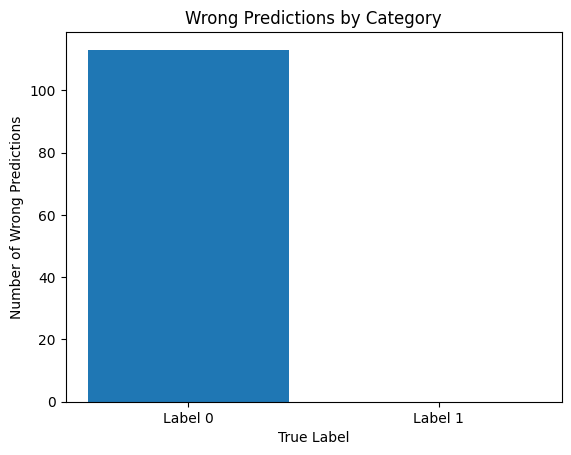

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfa1.iterrows():
    predictions = few_evaluator(dfdem, 2, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

## Table of Contents

- [Section 1: Zero shot inference](#cell-Bs8GNXS5ukzf)
- [Section 2: Few shot inference](#cell-9-vNLs8Vkfci)
- [Section 3: Related-example selection](#cell-S2k-8YErxHjm)
- [Section 4: More Error analysis](#cell-p1JrEjDluWpH)
  - [4.1: **Full Explainations on Error analysis**](#cell-a8XYa9r-TeLc)
- [Section 5: Cut tokenization overhead](#cell-cELyQNNDz4Lm)
- [Section 6: Ensemble Model](#cell-0rEcrKWh1kOi)
- [Section 7: Test on A1 dataset](#cell-0YMVGK3Y2XOW)
- [Section 8: Some more analyze with demonstration dataset as test](#cell-E1Bq2SdLlSCp)






# some experience only on demonstration dataset

| Model         | Example Ratio (Sexist : Not-Sexist) | Accuracy (%) (full dataset) |
|---------------|-------------------------------------|-----------------------------|
| **LLaMA**     | 1:1                                 | 58.4                         |
| **LLaMA**     | 2:2                                 | 71                           |
| **LLaMA**     | 3:3                                 | 55                           |
| **Phi-3**     | 1:1                                 | 66.9                         |
| **Phi-3**     | 2:2                                 | 68                           |
| **Phi-3**     | 3:3                                 | 63                           |


Test mistral with demo data set with

## in next step we apply few-shot-inference on mistral
### we test (2,3,4) number of examples on first 500 datapoints to understand which has promising results and wether the trend we found in previous stages present here also

Evaluation Metrics: {'accuracy': 0.636, 'fail_ratio': 0.0}
time spent: 10.944604134559631
Indices of wrong predictions: [0, 2, 11, 12, 14, 15, 16, 17, 21, 22, 29, 30, 31, 33, 35, 38, 40, 42, 51, 56, 61, 65, 67, 69, 70, 71, 75, 76, 77, 78, 84, 85, 88, 90, 94, 95, 98, 99, 103, 105, 106, 110, 112, 117, 120, 123, 129, 132, 147, 152, 154, 156, 157, 161, 162, 164, 165, 168, 169, 170, 171, 174, 175, 179, 183, 185, 189, 191, 192, 199, 200, 201, 205, 206, 209, 212, 214, 215, 216, 219, 221, 223, 226, 234, 238, 240, 242, 243, 246, 247, 249, 255, 259, 260, 265, 270, 272, 275, 283, 287, 292, 293, 294, 296, 299, 300, 302, 303, 306, 310, 311, 313, 318, 319, 320, 322, 327, 333, 336, 339, 340, 344, 347, 354, 356, 359, 362, 365, 367, 371, 377, 379, 382, 386, 388, 390, 398, 399, 401, 402, 403, 405, 406, 407, 408, 410, 411, 417, 418, 419, 420, 421, 429, 431, 439, 440, 444, 446, 451, 452, 453, 456, 459, 461, 462, 465, 471, 474, 475, 476, 477, 479, 482, 486, 489, 491, 492, 495, 496, 497, 498, 499]


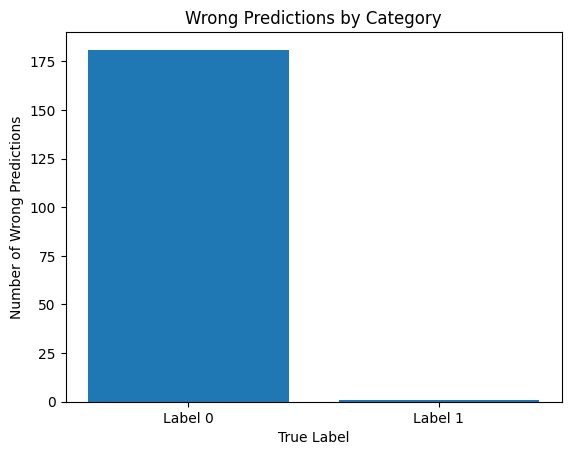

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem[0:500].iterrows():
    predictions = few_evaluator(dfdem, 2, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

Evaluation Metrics: {'accuracy': 0.698, 'fail_ratio': 0.0}
time spent: 10.847926930586498
Indices of wrong predictions: [0, 2, 12, 15, 17, 22, 30, 31, 40, 42, 51, 61, 65, 69, 76, 77, 78, 84, 85, 88, 95, 98, 103, 105, 106, 110, 112, 115, 117, 120, 123, 129, 147, 152, 154, 156, 161, 162, 164, 165, 168, 169, 170, 171, 174, 175, 179, 183, 185, 189, 191, 192, 199, 201, 205, 206, 212, 214, 215, 216, 219, 221, 223, 226, 234, 240, 242, 246, 247, 249, 255, 259, 260, 262, 265, 270, 272, 275, 279, 283, 287, 294, 296, 299, 300, 302, 303, 306, 309, 313, 318, 319, 320, 327, 332, 333, 336, 337, 339, 340, 344, 347, 354, 356, 359, 365, 371, 377, 382, 386, 388, 390, 401, 402, 403, 405, 407, 408, 410, 411, 417, 418, 420, 421, 426, 429, 431, 439, 440, 444, 451, 453, 455, 456, 461, 462, 465, 474, 475, 476, 477, 479, 482, 486, 489, 491, 492, 495, 496, 498, 499]


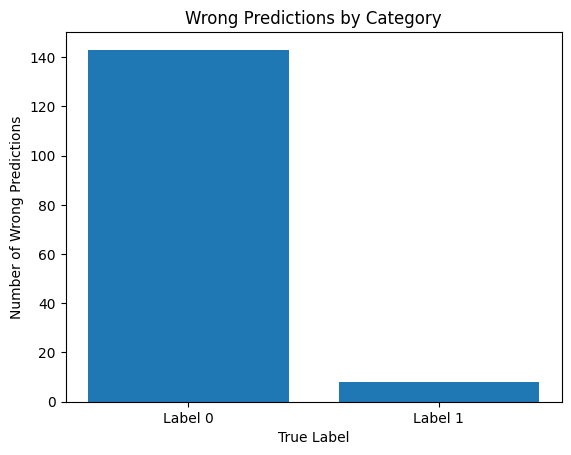

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem[0:500].iterrows():
    predictions = few_evaluator(dfdem, 4, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

Evaluation Metrics: {'accuracy': 0.692, 'fail_ratio': 0.0}
time spent: 11.791636542479198
Indices of wrong predictions: [0, 2, 12, 15, 16, 17, 22, 30, 31, 40, 42, 51, 61, 65, 69, 76, 77, 78, 84, 85, 88, 95, 103, 105, 106, 110, 112, 115, 117, 120, 123, 129, 132, 147, 152, 154, 156, 161, 162, 164, 165, 168, 169, 170, 171, 174, 175, 179, 183, 185, 189, 191, 192, 199, 201, 205, 206, 212, 214, 215, 216, 219, 221, 223, 226, 234, 240, 242, 243, 246, 247, 249, 255, 259, 262, 265, 270, 272, 275, 279, 283, 287, 294, 296, 299, 300, 302, 303, 306, 309, 311, 313, 318, 319, 320, 327, 332, 333, 336, 337, 339, 340, 344, 347, 354, 356, 359, 365, 371, 377, 379, 382, 386, 388, 392, 401, 402, 403, 405, 406, 407, 408, 410, 411, 417, 418, 420, 421, 426, 429, 431, 439, 440, 444, 453, 455, 456, 461, 462, 465, 474, 475, 476, 477, 479, 482, 486, 489, 491, 492, 495, 496, 498, 499]


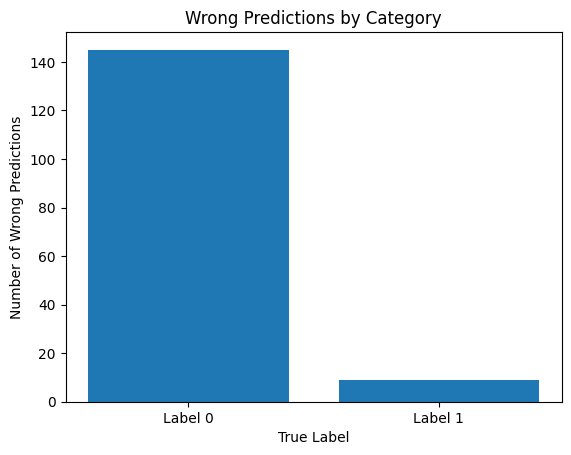

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem[0:500].iterrows():
    predictions = few_evaluator(dfdem, 6, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

#### As you can see with 4 number of examples we get most accuracy of all and the pattern is not same as phi-3 and llama
##### so in next step we calculate the accuracy on rest of datapoints to find the complete accuracy

Evaluation Metrics: {'accuracy': 0.7022222222222222, 'fail_ratio': 0.0}
time spent: 10.185207696755727
Indices of wrong predictions: [2, 3, 6, 8, 11, 13, 15, 21, 24, 26, 30, 34, 42, 51, 54, 56, 62, 66, 73, 74, 76, 78, 81, 82, 84, 87, 88, 89, 90, 96, 101, 103, 108, 115, 116, 118, 126, 130, 133, 137, 139, 144, 149, 150, 156, 159, 161, 162, 164, 166, 167, 173, 176, 179, 180, 181, 187, 188, 190, 194, 197, 198, 200, 203, 208, 211, 221, 223, 225, 226, 228, 229, 232, 233, 236, 238, 246, 247, 250, 252, 253, 257, 259, 263, 265, 268, 272, 273, 274, 276, 277, 279, 285, 287, 299, 301, 306, 308, 313, 316, 319, 322, 326, 328, 329, 332, 335, 338, 351, 357, 363, 366, 370, 382, 385, 389, 391, 392, 395, 396, 397, 400, 401, 404, 410, 412, 422, 423, 430, 435, 439, 441, 444, 447]


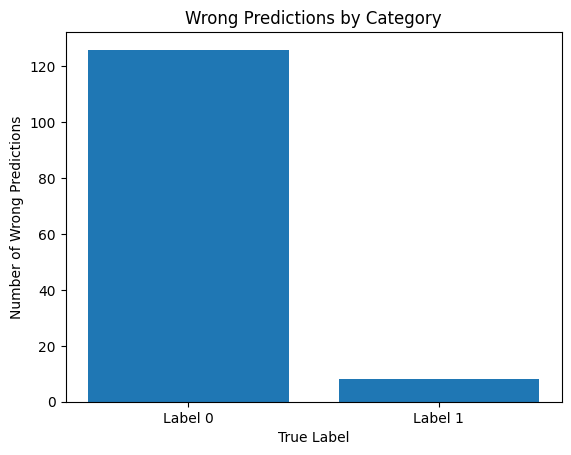

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem[550:1000].iterrows():
    predictions = few_evaluator(dfdem, 4, tokenizer_mistral, model_mistral, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_la_few, labels_la_few)

### the accuracy of mistral model with 4 number of examples on the whole demonstration dataset is 70.01% in 22 minutes

### Our idea to increase the accuracy is to use meta-ensemble model (logistic model) that use the answer for 3 models and came to a better conclusion
### in order to train our meta-ensemble model, we train it on a2-test dataset and then test it on demonstration dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def train_meta_ensemble(models, tokenizers, data, num_exmp, prompt_template):
    # Collect training data for meta-model
    meta_features = []
    meta_labels = []
    few_shot_examples, _ = build_few_shot_demonstrations(data, num_exmp)

    for text, label in zip(data["text"], data["label_sexist"]):
        features = []
        for model, tokenizer, phiB in zip(models, tokenizers, [True, True, True]):
            predictions = few_evaluator(data, num_exmp, tokenizer, model, prompt_template, [text], [label], phi=phiB)
            features.append(predictions[0])  # Append prediction for this model
        meta_features.append(features)
        meta_labels.append(label)

    # Train meta-classifier
    meta_model = LogisticRegression()
    meta_model.fit(meta_features, meta_labels)
    return meta_model

meta_model = train_meta_ensemble(models, tokenizers, dfa2, 4, prompt_few)

In [ ]:
def meta_ensemble_few_evaluator(meta_model, models, tokenizers, data, num_exmp, prompt_template, text, labels, key="ANSWER"):
    few_shot_examples, _ = build_few_shot_demonstrations(data, num_exmp)
    meta_features = []

    for text_item in text:
        features = []
        for model, tokenizer, phiB in zip(models, tokenizers, [True, True, True]):
            predictions = few_evaluator(data, num_exmp, tokenizer, model, prompt_template, [text_item], [0], phi=phiB, key=key)
            features.append(predictions[0])
        meta_features.append(features)

    # Use meta-classifier for final predictions
    final_predictions = meta_model.predict(meta_features)
    metrics, _, _ = compute_metrics(final_predictions, labels)
    #print(f"Meta-Ensemble Metrics: {metrics}")
    return final_predictions, labels

preds = []
labels = []

start_time = time.time()

# Iterate over the DataFrame rows
for _, row in dfdem[0:500].iterrows():
    predictions, true_labels = meta_ensemble_few_evaluator(
        meta_model=meta_model,
        models=models,
        tokenizers=tokenizers,
        data=dfdem,
        num_exmp=4,  # Number of few-shot examples
        prompt_template=prompt_few,  # Replace with your prompt template
        text=[row["text"]],  # Input text
        labels=[row["label_sexist"]],  # True labels
        key="ANSWER"  # Key for splitting responses
    )
    preds.extend(predictions)
    labels.extend(true_labels)

# Compute and print final metrics
metrics, preds_final, labels_final = compute_metrics(preds, labels)
print("Final Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")

Final Evaluation Metrics: {'accuracy': 0.698, 'fail_ratio': 0.0}
Time spent: 34.19450406630834


In [ ]:
preds = []
labels = []

start_time = time.time()

# Iterate over the DataFrame rows
for _, row in dfdem[500:1000].iterrows():
    predictions, true_labels = meta_ensemble_few_evaluator(
        meta_model=meta_model,
        models=models,
        tokenizers=tokenizers,
        data=dfdem,
        num_exmp=4,  # Number of few-shot examples
        prompt_template=prompt_few,  # Replace with your prompt template
        text=[row["text"]],  # Input text
        labels=[row["label_sexist"]],  # True labels
        key="ANSWER"  # Key for splitting responses
    )
    preds.extend(predictions)
    labels.extend(true_labels)

# Compute and print final metrics
metrics, preds_final, labels_final = compute_metrics(preds, labels)
print("Final Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")

Final Evaluation Metrics: {'accuracy': 0.71, 'fail_ratio': 0.0}
Time spent: 35.9213326215744


### as we observed the result on whole demonstration dataset is 70.5% in 1 hour

##### also worth to mention that we experimented normal voting ensembl method and weighted ensembel method with results below, however logistic shows better results in our tests
##### the result below is only for 30 datapoints, in which meta-ensemble (logistic reg) could achieve 80% in same data

In [ ]:
import time

def few_evaluator(data, num_exmp, tokenizer, model, prompt_template, text, labels, phi=True, key="ANSWER"):
    examples, _ = build_few_shot_demonstrations(data, num_exmp)
    tokenized_prompts = prepare_prompts_few(examples, text, prompt_template, tokenizer, phi=phi)    # Generate responses
    responses = generate_responses(model, tokenized_prompts, tokenizer)
    #print(responses)
    #print(responses)

    # Process responses into binary predictions
    predictions = []
    for response in responses:
        # Extract the last segment after the final "ANSWER"
        answer = split_string(response, key="ANSWER")
        #print(f"DEBUG: Extracted Answer: {answer}")  # Debugging extracted answer
        # Process the response to determine "YES" or "NO"
        predictions.append(process_response(answer))

    return predictions

def ensemble_few_evaluator(data, num_exmp, models, tokenizers, prompt_template, text, labels, phi=True, key="ANSWER"):
    # Build few-shot examples
    few_shot_examples, _ = build_few_shot_demonstrations(data, num_exmp)
    ensemble_predictions = []
    #print(few_shot_examples)

    # Iterate over models and tokenizers
    for model, tokenizer, phiB in zip(models, tokenizers,[True,True,True]):
        #print(phiB)
        ps = few_evaluator(data, num_exmp, tokenizer, model, prompt_template, text, labels, phi= phiB, key="ANSWER")
        ensemble_predictions.append(ps)

    # Combine predictions using majority voting
    final_predictions = []
    for i in range(len(text)):
        model_votes = [ensemble_predictions[j][i] for j in range(len(models))]
        final_prediction = max(set(model_votes), key=model_votes.count)  # Majority voting
        final_predictions.append(final_prediction)

    # Compute evaluation metrics
    metrics, _, _ = compute_metrics(final_predictions, labels)
    print(f"Evaluation Metrics: {metrics}")

    return final_predictions, labels

# Load Models
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch


# Combine Models and Tokenizers
models = [model_mistral, model_llama, model]
tokenizers = [tokenizer_mistral, tokenizer_llama, tokenizer_phi]

# Evaluate using ensemble
preds = []
labels = []
start_time = time.time()

for _, row in dfdem[0:30].iterrows():
    predictions, true_labels = ensemble_few_evaluator(
        dfdem,
        4,  # Number of examples
        models,
        tokenizers,
        prompt_few,  # Prompt template
        [row["text"]],
        [row["label_sexist"]],
        phi=False,  # Update based on the tokenizer type
        key="ANSWER"
    )

    preds.extend(predictions)
    labels.extend(true_labels)

# Compute final metrics
metrics, preds_final, labels_final = compute_metrics(preds, labels)
print("Final Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")


Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy'

In [ ]:
def ensemble_few_evaluator(data, num_exmp, models, tokenizers, prompt_template, text, labels, phi=True, key="ANSWER"):
    # Define weights based on model performance
    model_weights = [0.4, 0.3, 0.3]  # Adjust weights based on individual model performance

    # Build few-shot examples
    few_shot_examples, _ = build_few_shot_demonstrations(data, num_exmp)
    weighted_predictions = []

    # Iterate over models and tokenizers
    for model, tokenizer, phiB, weight in zip(models, tokenizers, [True, True, True], model_weights):
        # Get predictions for the current model
        predictions = few_evaluator(data, num_exmp, tokenizer, model, prompt_template, text, labels, phi=phiB, key=key)

        # Weight the predictions
        weighted_predictions.append((predictions, weight))

    # Combine predictions using weighted voting
    final_predictions = []
    for i in range(len(text)):
        votes = {}
        for predictions, weight in weighted_predictions:
            pred = predictions[i]
            votes[pred] = votes.get(pred, 0) + weight
        final_prediction = max(votes, key=votes.get)  # Choose the prediction with the highest weighted vote
        final_predictions.append(final_prediction)

    # Compute evaluation metrics
    metrics, _, _ = compute_metrics(final_predictions, labels)
    print(f"Evaluation Metrics: {metrics}")

    return final_predictions, labels

# Evaluate using ensemble
preds = []
labels = []
start_time = time.time()

for _, row in dfdem[0:30].iterrows():
    predictions, true_labels = ensemble_few_evaluator(
        dfdem,
        4,  # Number of examples
        models,
        tokenizers,
        prompt_few,  # Prompt template
        [row["text"]],
        [row["label_sexist"]],
        phi=False,  # Update based on the tokenizer type
        key="ANSWER"
    )

    preds.extend(predictions)
    labels.extend(true_labels)

# Compute final metrics
metrics, preds_final, labels_final = compute_metrics(preds, labels)
print("Final Evaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent}")




Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 1.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy': 0.0, 'fail_ratio': 0.0}
Evaluation Metrics: {'accuracy'

### on first 30 datapoint meta-ensembel model got accuracy of 80%

### Run Llama model on demonstration dataset, in few shot inference mode, with 2 number of examples (1:1)

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem.iterrows():
    predictions = few_evaluator(dfdem, 2, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few2, labels_la_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))


Evaluation Metrics: {'accuracy': 0.584, 'fail_ratio': 0.0}
time spent: 13.893539615472157


Indices of wrong predictions: [0, 2, 12, 14, 15, 16, 17, 21, 22, 29, 30, 31, 33, 38, 40, 42, 44, 50, 51, 56, 59, 61, 63, 65, 67, 69, 71, 72, 75, 76, 77, 78, 84, 85, 87, 88, 90, 91, 94, 95, 98, 99, 105, 106, 107, 109, 110, 112, 117, 120, 123, 129, 130, 132, 139, 142, 146, 147, 152, 154, 156, 157, 159, 161, 162, 164, 165, 168, 169, 170, 171, 172, 174, 175, 178, 179, 183, 185, 191, 192, 199, 200, 201, 205, 206, 209, 212, 214, 215, 216, 219, 221, 223, 226, 234, 236, 238, 239, 240, 242, 243, 246, 247, 249, 255, 259, 260, 265, 268, 270, 272, 275, 281, 282, 283, 287, 289, 292, 293, 294, 296, 298, 299, 300, 302, 303, 306, 310, 311, 313, 316, 317, 318, 319, 320, 322, 326, 327, 333, 335, 336, 337, 339, 340, 344, 346, 347, 354, 356, 359, 360, 365, 369, 371, 377, 379, 380, 382, 385, 386, 388, 390, 391, 394, 396, 398, 399, 401, 402, 403, 405, 406, 407, 408, 410, 411, 412, 416, 417, 418, 419, 420, 421, 422, 429, 431, 439, 440, 444, 446, 450, 451, 452, 453, 456, 459, 461, 462, 463, 465, 474, 475, 476

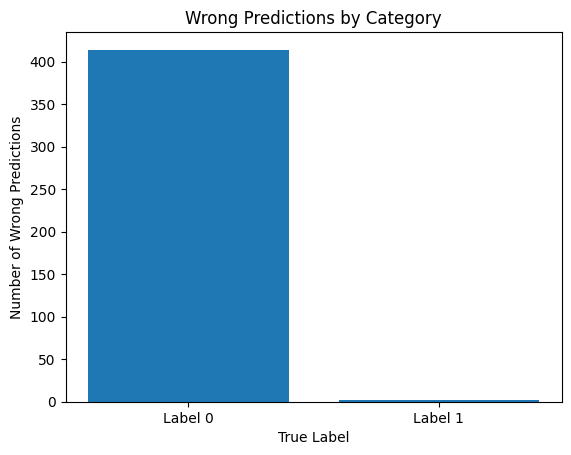

In [ ]:
analyze_wrong_predictions(preds_la_few2, labels_la_few2)

### Run phi-3 model on demonstration dataset, in few shot inference mode, with 2 number of examples (1:1)

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem.iterrows():
    predictions = few_evaluator(dfdem, 2, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))


Evaluation Metrics: {'accuracy': 0.669, 'fail_ratio': 0.0}
time spent: 24.81914213895798


### Run phi-3 model on demonstration dataset, in few shot inference mode, with 6 number of examples (3:3)

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem.iterrows():
    predictions = few_evaluator(dfdem, 6, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_phi_few, labels_phi_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))


Evaluation Metrics: {'accuracy': 0.63, 'fail_ratio': 0.0}
time spent: 25.302171043554942


Indices of wrong predictions: [0, 9, 12, 14, 16, 17, 20, 21, 22, 29, 30, 31, 32, 33, 35, 38, 42, 44, 51, 53, 54, 56, 61, 63, 65, 69, 70, 76, 80, 88, 89, 95, 99, 105, 110, 117, 120, 122, 129, 132, 135, 147, 151, 152, 154, 156, 161, 162, 164, 168, 169, 171, 174, 175, 177, 179, 187, 192, 199, 200, 201, 203, 205, 209, 212, 213, 214, 215, 216, 219, 221, 223, 226, 227, 232, 233, 234, 236, 237, 238, 239, 240, 243, 245, 247, 249, 257, 259, 265, 270, 272, 273, 275, 283, 287, 290, 294, 295, 296, 298, 299, 302, 303, 306, 310, 311, 313, 316, 317, 318, 319, 320, 322, 325, 327, 333, 336, 337, 339, 340, 344, 346, 347, 354, 356, 357, 359, 362, 366, 367, 369, 371, 374, 377, 379, 382, 386, 388, 390, 395, 396, 400, 401, 402, 405, 407, 408, 410, 411, 418, 419, 420, 421, 422, 423, 431, 439, 444, 446, 450, 451, 454, 459, 462, 463, 465, 473, 475, 477, 478, 484, 486, 491, 496, 497, 498, 499, 500, 501, 504, 505, 507, 508, 510, 511, 513, 515, 516, 523, 527, 528, 529, 530, 532, 536, 537, 539, 540, 545, 546, 547,

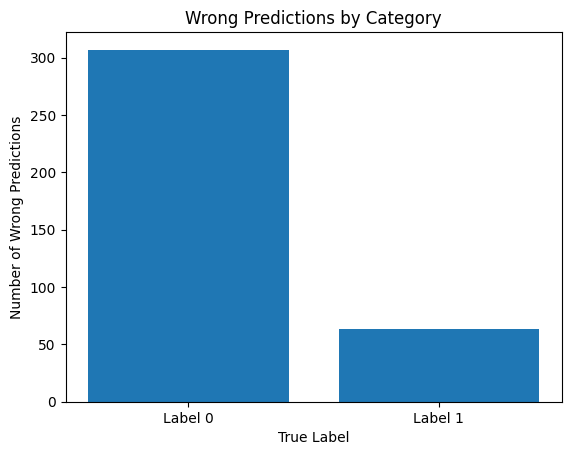

In [ ]:
analyze_wrong_predictions(preds_phi_few, labels_phi_few)

### Run Llama model on demonstration dataset, in few shot inference mode, with 6 number of examples (3:3)

In [ ]:

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem.iterrows():
    predictions = few_evaluator(dfdem, 6, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few, labels_la_few = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))


Evaluation Metrics: {'accuracy': 0.553, 'fail_ratio': 0.0}
time spent: 19.648661422729493


Indices of wrong predictions: [0, 2, 11, 12, 14, 15, 16, 17, 22, 29, 30, 31, 32, 33, 38, 40, 42, 44, 45, 50, 51, 56, 59, 61, 63, 65, 67, 69, 70, 71, 72, 75, 76, 77, 78, 84, 85, 87, 88, 91, 94, 95, 98, 99, 103, 105, 106, 109, 110, 112, 117, 120, 123, 129, 130, 132, 139, 146, 147, 152, 154, 156, 157, 159, 161, 162, 164, 165, 168, 169, 170, 171, 172, 173, 174, 175, 178, 179, 183, 185, 191, 192, 199, 200, 201, 205, 206, 209, 212, 214, 215, 216, 219, 221, 223, 226, 234, 236, 238, 239, 240, 242, 243, 245, 246, 247, 249, 255, 257, 259, 260, 265, 268, 270, 272, 273, 275, 278, 281, 282, 283, 287, 289, 292, 293, 294, 296, 298, 299, 300, 302, 303, 306, 310, 311, 313, 316, 317, 318, 319, 320, 322, 326, 327, 333, 335, 336, 337, 339, 340, 344, 346, 347, 354, 356, 359, 360, 362, 365, 369, 371, 377, 379, 382, 385, 386, 387, 388, 390, 391, 396, 398, 401, 402, 403, 405, 406, 407, 408, 410, 411, 412, 416, 417, 418, 419, 420, 421, 422, 427, 429, 431, 434, 439, 440, 442, 444, 446, 450, 451, 452, 453, 456, 

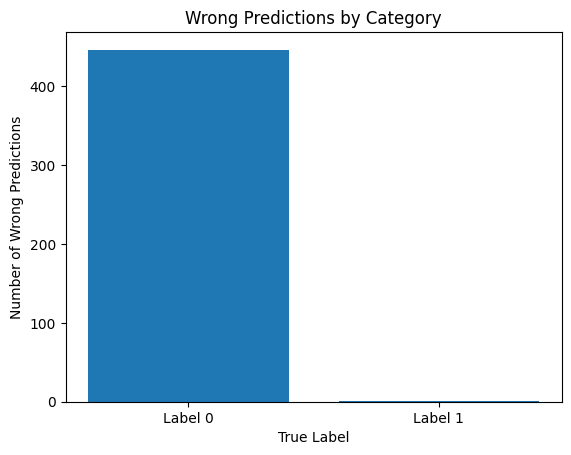

In [ ]:
analyze_wrong_predictions(preds_la_few, labels_la_few)

### Run Llama model on demonstration dataset, in few shot inference mode, with 4 number of examples (2:2)

In [ ]:
import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem.iterrows():
    predictions = few_evaluator(dfdem, 4, tokenizer_llama, model_llama, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_la_few2, labels_la_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))


Evaluation Metrics: {'accuracy': 0.71, 'fail_ratio': 0.0}
time spent: 17.810371057192484


Indices of wrong predictions: [0, 12, 15, 17, 22, 30, 31, 40, 42, 51, 56, 61, 65, 69, 76, 77, 78, 84, 85, 88, 105, 106, 110, 117, 120, 123, 129, 132, 147, 152, 154, 156, 159, 161, 162, 169, 170, 171, 174, 175, 179, 183, 185, 189, 191, 192, 200, 201, 205, 206, 212, 214, 215, 216, 219, 221, 223, 226, 234, 236, 240, 242, 246, 247, 249, 255, 259, 260, 265, 269, 270, 272, 275, 282, 283, 289, 293, 294, 296, 299, 302, 303, 310, 313, 315, 318, 319, 320, 322, 327, 332, 333, 336, 337, 339, 340, 344, 346, 347, 354, 356, 359, 366, 371, 377, 379, 382, 386, 388, 390, 391, 398, 401, 402, 403, 405, 406, 407, 408, 410, 411, 412, 417, 418, 420, 421, 426, 429, 431, 437, 439, 440, 450, 453, 463, 464, 474, 475, 476, 479, 482, 486, 489, 491, 492, 495, 496, 497, 498, 499, 500, 501, 504, 507, 508, 511, 512, 515, 516, 521, 523, 528, 530, 532, 535, 540, 543, 552, 553, 558, 561, 563, 570, 574, 576, 577, 580, 581, 592, 593, 601, 604, 606, 611, 616, 623, 624, 626, 627, 628, 631, 632, 634, 637, 638, 639, 640, 646, 

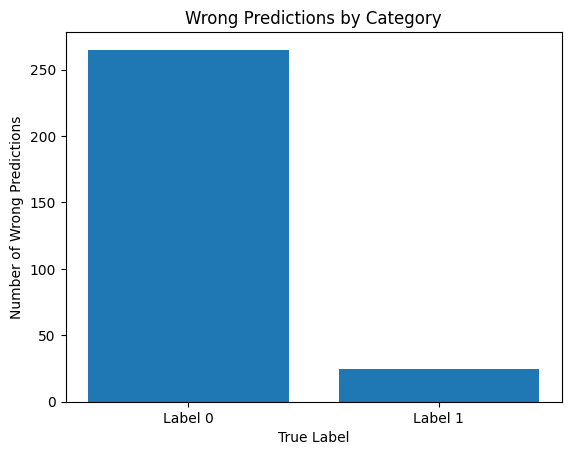

In [ ]:
analyze_wrong_predictions(preds_la_few2, labels_la_few2)

### Run phi-3 model on demonstration dataset, in few shot inference mode, with 4 number of examples (2:2)

Evaluation Metrics: {'accuracy': 0.68, 'fail_ratio': 0.004}
time spent: 26.2362157424291
Indices of wrong predictions: [0, 2, 9, 12, 30, 31, 42, 43, 44, 51, 53, 56, 59, 61, 63, 65, 69, 70, 76, 78, 80, 88, 89, 95, 102, 105, 110, 117, 120, 129, 132, 135, 142, 143, 147, 151, 152, 154, 156, 161, 162, 168, 169, 171, 174, 179, 187, 189, 199, 200, 201, 203, 205, 206, 209, 212, 214, 215, 216, 219, 221, 223, 226, 227, 230, 232, 234, 236, 237, 238, 240, 243, 247, 249, 263, 265, 269, 270, 272, 275, 281, 283, 288, 289, 290, 294, 296, 299, 302, 303, 305, 306, 309, 311, 313, 317, 318, 319, 320, 322, 327, 333, 336, 337, 339, 340, 344, 346, 347, 354, 356, 357, 359, 362, 366, 369, 370, 371, 374, 377, 379, 382, 386, 387, 388, 390, 392, 400, 401, 403, 405, 407, 408, 410, 411, 418, 419, 421, 423, 425, 426, 427, 431, 439, 440, 446, 450, 463, 465, 471, 473, 475, 476, 477, 479, 484, 486, 491, 492, 495, 496, 498, 499, 500, 501, 505, 506, 507, 508, 510, 511, 513, 516, 521, 523, 528, 529, 530, 535, 536, 537, 53

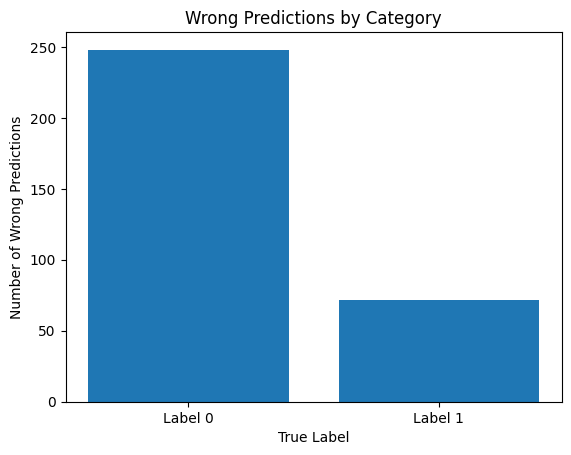

In [ ]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2, exm_mode=True):
    demonstrations = demonstrations.dropna(subset=['label_sexist'])

    examples = []
    labels = []

    if exm_mode:
        share = 2
        for label, label_str in [(0, "NO"), (1, "YES")]:

            sampled_examples = demonstrations[demonstrations["label_sexist"] == label].sample(
                n=min(share, len(demonstrations[demonstrations["label_sexist"] == label])),
                random_state=42,
                replace=True
            )
            share = 2

            for _, row in sampled_examples.iterrows():
                examples.append(f"Text: {row['text']}\nANSWER: {label_str}")
    else:
        sampled = demonstrations.sample(n=min(num_per_class, len(demonstrations)), random_state=42, replace=True)
        for _, row in sampled.iterrows():
            examples.append(row["text"])
            labels.append(row["label_sexist"])

    return examples, labels

import time
import warnings

warnings.filterwarnings("ignore")

preds = []
labels = []
start_time = time.time()

for _, row in dfdem.iterrows():
    predictions = few_evaluator(dfdem, 4, tokenizer_phi, model, prompt_few, [row["text"]], [row["label_sexist"]])
    labels.append(row["label_sexist"])
    preds.extend(predictions)

metrics, preds_phi_few2, labels_phi_few2 = compute_metrics(preds, labels)
print("Evaluation Metrics:", metrics)
#print(compute_metrics(preds,labels))
end_time = time.time()
time_spent = (end_time - start_time)/60
print("time spent: {}".format(time_spent))
analyze_wrong_predictions(preds_phi_few2, labels_phi_few2)

### in another experiment we used the more intelligent example injections
### instead of pick random examples, we inject the examples which are more similar to the text we want to evaluate
### our intuition was that it could increase the accuracy and time consumption

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load a lightweight embedding model
model_embed = SentenceTransformer('all-MiniLM-L6-v2')  # Pretrained model for embeddings

# Precompute embeddings for all dataset examples
example_texts = dfdem['text'].tolist()  # Adjust column name to match your dataset
example_embeddings = model_embed.encode(example_texts, convert_to_tensor=True)

# Define a function to retrieve the most relevant few-shot examples
def retrieve_relevant_examples(query, top_k=4):
    """
    Retrieve the most relevant few-shot examples for the given query.

    Args:
    - query (str): The input query text.
    - top_k (int): Number of relevant examples to retrieve.

    Returns:
    - List of top-k most similar examples.
    """
    query_embedding = model_embed.encode(query, convert_to_tensor=True)
    similarities = util.pytorch_cos_sim(query_embedding, example_embeddings)
    top_indices = similarities.topk(k=top_k).indices[0].tolist()
    return [example_texts[i] for i in top_indices]


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
import os
import logging
from sentence_transformers import LoggingHandler

os.environ["TOKENIZERS_PARALLELISM"] = "false"
logging.basicConfig(level=logging.ERROR)  # Set logging to ERROR to reduce verbosity

def few_evaluator_with_retrieval(data, tokenizer, model, prompt_template, text, labels, top_k=4, phi=True, key="ANSWER"):
    predictions = []

    for query_text, label in zip(text, labels):
        relevant_examples = retrieve_relevant_examples(query_text, top_k=top_k)
        tokenized_prompts = prepare_prompts_few(relevant_examples, [query_text], prompt_template, tokenizer, phi=phi)
        responses = generate_responses(model, tokenized_prompts, tokenizer)
        for response in responses:
            answer = split_string(response, key=key)
            predictions.append(process_response(answer))

    return predictions

def retrieve_relevant_examples(query, top_k=4):
    query_embedding = model_embed.encode(query, convert_to_tensor=True, show_progress_bar=False)
    similarities = util.pytorch_cos_sim(query_embedding, example_embeddings)
    top_indices = similarities.topk(k=top_k).indices[0].tolist()
    return [example_texts[i] for i in top_indices]

preds = []
labels = []
start_time = time.time()

print("Starting evaluation...")

for idx, row in enumerate(dfdem.iterrows()):
    predictions = few_evaluator_with_retrieval(
        dfdem,  # Full dataset for retrieval
        tokenizer_llama,
        model_llama,
        prompt_few,
        [row[1]["text"]],  # Query text
        [row[1]["label_sexist"]],  # True label
        top_k=4,
        phi=True
    )
    labels.append(row[1]["label_sexist"])
    preds.extend(predictions)

    if (idx + 1) % 10 == 0 or idx + 1 == len(dfdem):
        print(f"Processed {idx + 1}/{len(dfdem)} rows...")

metrics, preds_final, labels_final = compute_metrics(preds, labels)
print("\nEvaluation Metrics:", metrics)

end_time = time.time()
time_spent = (end_time - start_time) / 60
print(f"Time spent: {time_spent:.2f} minutes")


Starting evaluation...
Processed 10/1000 rows...
Processed 20/1000 rows...
Processed 30/1000 rows...
Processed 40/1000 rows...
Processed 50/1000 rows...
Processed 60/1000 rows...
Processed 70/1000 rows...
Processed 80/1000 rows...
Processed 90/1000 rows...
Processed 100/1000 rows...
Processed 110/1000 rows...
Processed 120/1000 rows...
Processed 130/1000 rows...
Processed 140/1000 rows...
Processed 150/1000 rows...
Processed 160/1000 rows...
Processed 170/1000 rows...
Processed 180/1000 rows...
Processed 190/1000 rows...
Processed 200/1000 rows...
Processed 210/1000 rows...
Processed 220/1000 rows...
Processed 230/1000 rows...
Processed 240/1000 rows...
Processed 250/1000 rows...
Processed 260/1000 rows...
Processed 270/1000 rows...
Processed 280/1000 rows...
Processed 290/1000 rows...
Processed 300/1000 rows...
Processed 310/1000 rows...
Processed 320/1000 rows...
Processed 330/1000 rows...
Processed 340/1000 rows...
Processed 350/1000 rows...
Processed 360/1000 rows...
Processed 370/

### result shows that this method, couldn't increase neither the accuracy nor the time consumptions

## Table of Contents

- [Section 1: Zero shot inference](#cell-Bs8GNXS5ukzf)
- [Section 2: Few shot inference](#cell-9-vNLs8Vkfci)
- [Section 3: Related-example selection](#cell-S2k-8YErxHjm)
- [Section 4: More Error analysis](#cell-p1JrEjDluWpH)
- [Section 5: Cut tokenization overhead](#cell-cELyQNNDz4Lm)
- [Section 6: Ensemble Model](#cell-0rEcrKWh1kOi)
- [Section 7: Test on A1 dataset](#cell-0YMVGK3Y2XOW)
- [Section 8: Some more analyze with demonstration dataset as test](#cell-E1Bq2SdLlSCp)




